In [1]:
# repository:
#     url: https://github.com/{your-book-url}


In [2]:
from numba import jit, cuda, float64
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.pyplot import figure
import random
import seaborn as sns
np.random.seed(13697)  #13699
random.seed(586)     #586
sns.set()
import plotly.figure_factory as ff
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_percentage_error,mean_absolute_error

import scipy.linalg as sla
from struct_tools import DotDict

In [3]:
# data = pd.read_table('./GasProductionData_RateTime.txt')


In [4]:
# time = np.array(data['time'][1:])
# Rate=np.array(data['Rate'][1:])

In [5]:
# plt.plot(time,Rate,'o')

### Forward model functions

In [6]:
# # 'This function calculates the instantanous flow rate of an exponential decline curve
def hyperbolicArps(t,q0, Di, b):
    return q0 / (1 + b * Di * t) ** (1 / b)
def exponentialArps(q0, Di, t):
    return q0 * np.exp(-Di * t)
def harmonicArps(t, q0, Di):
    return q0/(1 + Di * t)
def ArpsRate(t,q0, Di, b): 
#     b=np.tanh(b)                                    #scaling to 0-1 dimension
#     b=np.where(b<0,0,b)                             #truncating
    b = np.where(b<=0, 10**-5,b)

    return np.where(b==10**-5, exponentialArps(q0, Di, t),
                    np.where(b==1,harmonicArps(t, q0, Di),
                             hyperbolicArps(t,q0, Di, b)))
#SEM is being used for unconventinal field and here explain the turth for us.
def SEM(t,q0,Tau,n):
    Tau = np.where(Tau<=0, 10**-5,Tau)
    n = np.where(n<=0, 10**-5,n)
    return q0 *np.exp(-(t/Tau)**n)

In [7]:
def plotter(df,FM,tme,trp):
    for i in range(len(range(tme))):
        plt.figure(figsize=(12,9))
        Q0=df[0,:,i]
        par1=df[1,:,i]
        par2=df[2,:,i]
     
        if FM=='Arps':
            Qt=ArpsRate(np.array([range(tme)]).T, Q0 ,par1 , par2)          #Arps(time, Q, Di0, b)
        else:
            Qt=SEM(np.array(([range(tme)])*N).T, Q0 ,par1,par2)  #SEM(time, Q, Tau, n)
     
        
        plt.errorbar(T,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7,)
        if trp == True:
            plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=7,alpha=.5)
        plt.plot(Qt)
        plt.title('Update after {} observastion '.format(i+1))
        plt.show()
    return Qt

In [8]:
def triangular_samples(minimum,mode,maximum,N_samples):
#     samples = np.zeros(int(N_samples))
    loc = minimum
    scale = maximum - minimum
    c = (mode - loc)/scale
    samples = ss.triang.rvs(c, loc, scale, N_samples)
    return samples

In [9]:
def uniform_samples(minimum, maximum, N_samples):
    samples = np.zeros(int(N_samples))
    loc = minimum
    scale = maximum - loc
    samples = ss.uniform.rvs(loc, scale, N_samples)
    return samples

In [10]:
def Normal_samples(mean_norm,sd_norm,N_samples):
    samples = np.zeros(int(N_samples))
    samples = ss.norm.rvs(mean_norm,sd_norm,N_samples)
    return samples

In [11]:
def lognormal_samples(mean_lognormal, sd_lognormal, N_samples):
#     samples = np.zeros(int(N_samples))
    mean_normal = np.log(mean_lognormal**2/np.sqrt(sd_lognormal**2+mean_lognormal**2))
    sd_normal = np.sqrt(np.log(1+sd_lognormal**2/mean_lognormal**2))
    samples = ss.lognorm.rvs(s=sd_normal, scale=np.exp(mean_normal), size=N_samples,)
    return samples

In [12]:
# Program to calculate moving average
def MA(arr, window_size):
    window_size = 3
    i = 0
    moving_averages = []
    while i < len(arr) - window_size + 1:
        window = arr[i : i + window_size]
        window_average = round(sum(window) / window_size, 2)
        moving_averages.append(window_average)
        i += 1

    return moving_averages

In [13]:
def p(arrY,lst, window_size=10):
    fig, ax = plt.subplots(figsize=(7,8))
    ss = pd.Series(arrY)
    ss.rolling(window_size).mean().plot(ax=ax,label='mean')
    ss.rolling(window_size).std().plot(ax=ax,label='STD')
    ss.rolling(window_size).quantile(.1, interpolation='linear').plot(ax=ax,label='P10')
    ss.rolling(window_size).quantile(.9, interpolation='linear').plot(ax=ax,label='P90')
    ss.rolling(window_size).quantile(.5, interpolation='linear').plot(ax=ax,label='P50')
    ax.legend()
    ax.set_ylabel("mismatch")
    ax.set_xlabel("model of Qt")
    sns.jointplot(data=lst)
def movingaverage(x,y, window_size=10):
    window = np.ones(int(window_size))/float(window_size)
    y_av = np.convolve(y, window, 'same')
    plt.figure(figsize=(7,8))
    plt.plot(x,y,"k.")
    plt.plot(x, y_av,"r")
    plt.xlim(0,1000)
    plt.xlabel("Model.")
    plt.ylabel("mismatich")
    plt.grid(True)
    plt.show()
# def plot_p():
def M(arrX,arrY, point,radious):
    df=np.vstack((arrX,arrY)).T
    lst=[]
    for i in range(len(arrX)):
        if (df[i,0]>= point-radious)& (df[i,0]<=point+radious):
            lst.append(df[i,1])
    if len(lst)==0:
        print( "Not in range")
        return 
    print(len(lst))        
    mu=np.mean(lst)
    sd=np.std(lst)
    PC=np.percentile(lst,[10,50,90])
    dic={'mean':[mu,'r'], 'STD': [sd,'b'], 'P10':[PC[0],'y'], 'P50':[PC[1],'g'], 'P90':[PC[2],'k']}
    #####
    movingaverage(arrX, arrY)
    p(arrY,lst)
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(15,10))
    sns.kdeplot(lst,ax=axes[0]).set_title("dist at point")
    for key, val in dic.items():
        axes[0].axvline(x=val[0],linewidth=4, color=val[1], label=key)
        axes[0].legend()
    return dic

In [14]:
def RMSE (predict, true):
    rmse= mean_squared_error(true, predict,squared= False)
#     acs = accuracy_score(true, predict, )
    mape = mean_absolute_error(true, predict)
    
    return rmse,mape


In [15]:
def error(df, FM, tme,tr ,obs):
    Q0=df[0,:,-1]
    par1=df[1,:,-1]
    par2=df[2,:,-1]
     
    if FM=='Arps':
        Qt=ArpsRate(np.array([range(tme)]).T, Q0 ,par1 , par2)          #Arps(time, Q, Di0, b)
    else:
        Qt=SEM(np.array(([range(tme)])*N).T, Q0 ,par1,par2)  #SEM(time, Q, Tau, n)
        
        
        
    rmse1,mape1 = RMSE ( (np.array(obs_SEM) * np.ones((N,len(T)))),Qt.T)
    rmse2,mape2 = RMSE ( (np.array(tr) * np.ones((N,len(T)))),Qt.T)
    
    print("RMSE SEM_update/measrment is ",rmse1)
    print("RMSE SEM_update/ture is ",rmse2)
    
#     print("accuracy_score SEM_update/measrment is ",acs1)
#     print("accuracy_score SEM_update/ture is ",acs2) 
    
    print("MAPE SEM_update/measrment is ",mape1)
    print("MAPE SEM_update/ture is ",mape2 )
    

In [16]:
def p(matY,lst, win_size_fraction=0.05):
    window_size=int(win_size_fraction*matY.size)    #fraction is about fraction of size of window to calculate needed paramter
    fig, ax = plt.subplots()
    ss = pd.Series(matY.flatten())
    ss.rolling(window_size).mean().plot(ax=ax,label='mean')
    ss.rolling(window_size).std().plot(ax=ax,label='STD')
    ss.rolling(window_size).quantile(.1, interpolation='linear').plot(ax=ax,label='P10')
    ss.rolling(window_size).quantile(.9, interpolation='linear').plot(ax=ax,label='P90')
    ss.rolling(window_size).quantile(.5, interpolation='linear').plot(ax=ax,label='P50')
    ax.legend()
    sns.jointplot(data=lst.flatten(),kind='hex')

##  Generating N realization of truth in time of production

In [17]:
N = 100 # No.Realization
prod_time=15 #times
T = np.arange(0,prod_time)
T = np.linspace(0,1,prod_time)
Q_SEM = np.zeros((prod_time,N))
SEM_par=np.zeros((3,N))
for i in range(N):
    Tau_sample = uniform_samples(.01,1,1)
    n_sample = uniform_samples(0.1,1,1)
    T = np.arange(0,prod_time)
#     Q1=np.linspace(0,1000,1)[::-1]     #Also can chane it in a way to make different Qini Q fin)
#     Q1=lognormal_samples(1000,5, 1)
    Q1=uniform_samples(100,1500,1)
    Q_SEM[:,i]=SEM(T,Q1,Tau_sample,n_sample)
    SEM_par[0,i]=Q1[0]
    SEM_par[1,i]=Tau_sample
    SEM_par[2,i]=n_sample
QS_DF=pd.DataFrame(Q_SEM,columns=['realization'+str(i) for i in range(N)])

# QS_DF['Time']=pd.Series(T)   

In [18]:
# QS_DF

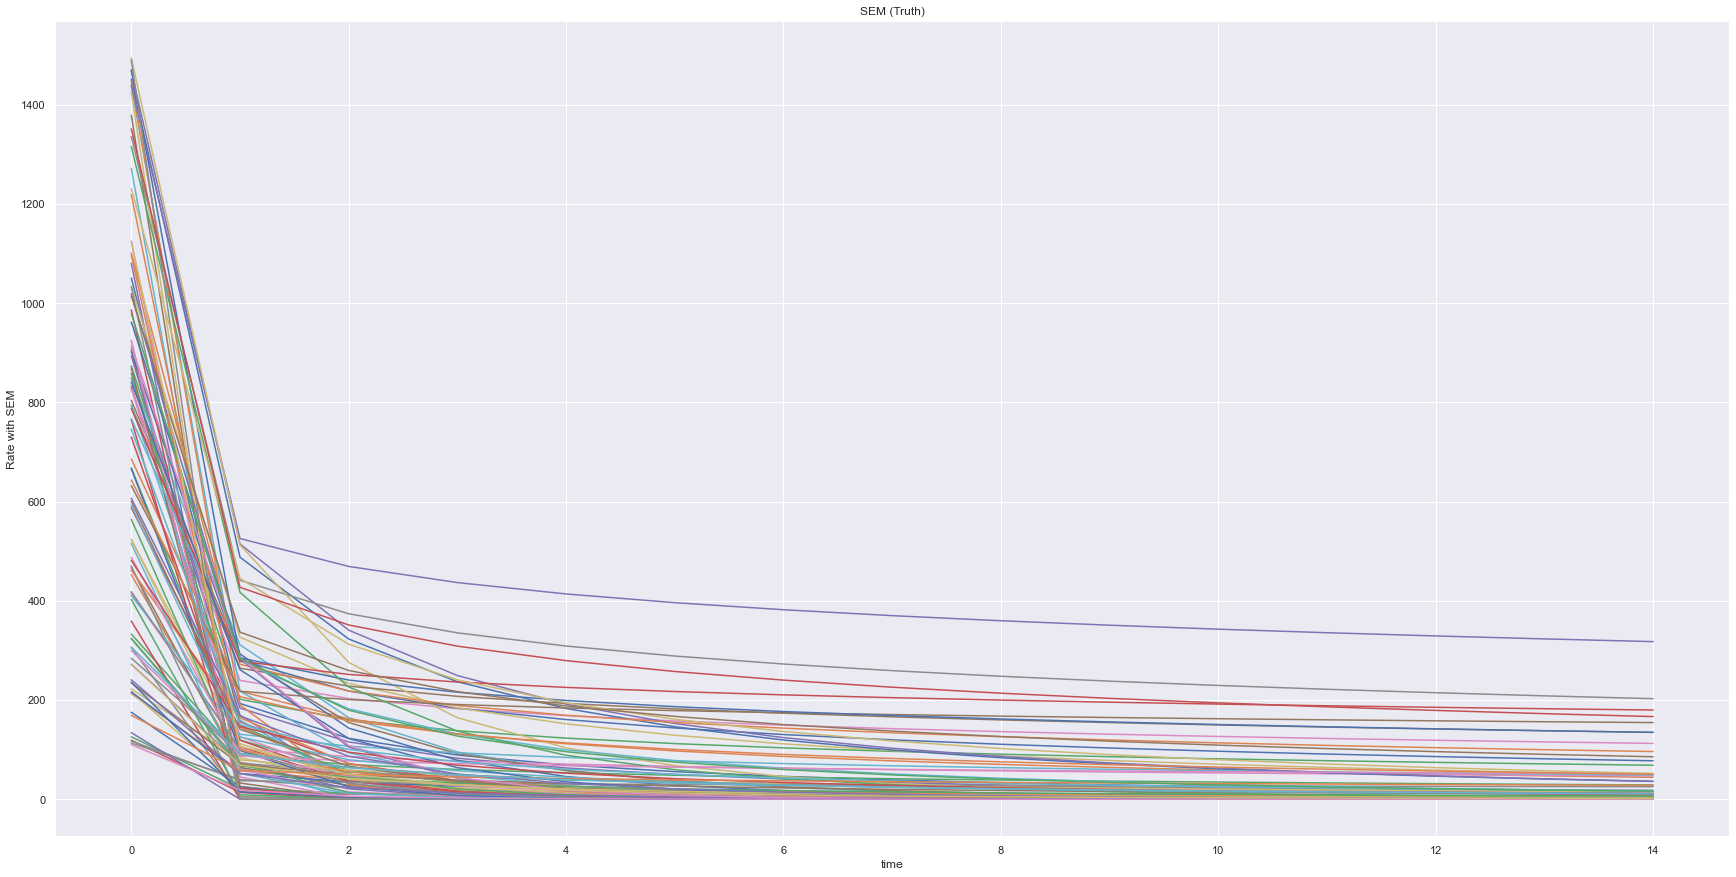

In [19]:
plt.figure(figsize=(30,15))
plt.plot(QS_DF)
plt.title('SEM (Truth)')
plt.xlabel('time')
plt.ylabel('Rate with SEM')
plt.show()

In [20]:
# SEM_T = go.Figure()
# for key, value in QS_DF.iteritems():
#     SEM_T.add_trace(go.Scatter(x=T, y=QS_DF[(key)], mode='lines', name=str(key), line=dict(color='gray')))
# SEM_T.update_layout(title={'text':'SEM Decline(True)','x':0.5,'y':0.85}, xaxis_title='Time (days)', yaxis_title='Oil Rate (bbl/day)')
# #fig_arps.update_layout(legend=dict(x=0.1,y=0.9,traceorder='normal',font=dict(size=15,)))
# SEM_T.show()

C:\Users\siava\anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:110: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         9.4977e+05                                    1.38e+03    
       1              2         9.1556e+05      3.42e+04       2.51e+01       1.35e+03    
       2              3         8.4902e+05      6.65e+04       5.01e+01       1.30e+03    
       3              4         7.2347e+05      1.26e+05       1.01e+02       1.20e+03    
       4              5         5.0249e+05      2.21e+05       2.00e+02       1.00e+03    
       5              6         1.8101e+05      3.21e+05       4.01e+02       6.02e+02    
       6              7         3.3119e-05      1.81e+05       6.02e+02       2.86e-07    
       7             13         3.2597e-05      5.22e-07       6.89e-02       4.34e-05    
       8             14         7.4869e-06      2.51e-05       1.38e-01       1.61e-03    
       9             15         1.0981e-06      6.39e-06       1.95e-01       1.16e-03    

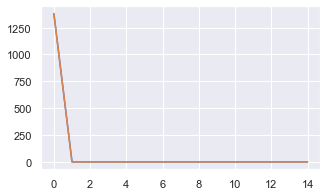

In [21]:
y=QS_DF['realization15']
T_=T
noise_sigma = T_/1
noise = np.ones((prod_time))   #np.random.randn(n) * noise_sigma
params2,cov = curve_fit(ArpsRate,T_,y/1,bounds=([0.0,.1,0.0],[np.inf,50,2]),method = 'dogbox',verbose=2,sigma=1/noise**2,ftol =1e-99, absolute_sigma=True)
                            # po:range ,sill ,nugget 
q = params2[0]
D = params2[1]
b = params2[2]

print('for exponential variogram')
print('Q is:',round(q,9))
print('D is:',round(D,4))
print('b:',round(b,8))
print(cov)
plt.figure(figsize=(5,3))
plt.plot(T_,y)
plt.plot(T_,ArpsRate(T,q, D,b))

In [22]:
para_mat=np.zeros((3,N))
Cov_mat=np.zeros((3,N,3))
T_=T/max(T)

noise_sigma = T_/20

for i,column in tqdm(enumerate(QS_DF)):
    noise = np.random.rand(prod_time) * noise_sigma
    noise[noise<=0]=.01
    params,cov = curve_fit(ArpsRate,T_,QS_DF[column]/1, method ='trf',bounds=([0,.1,0.0001],[np.inf,3,.99999]),ftol=1.e-16,verbose=0,sigma=1/noise**2,
                           absolute_sigma=True)
    para_mat[:,i]=params
    Cov_mat[:,i,:]=cov
    

0it [00:00, ?it/s]

C:\Users\siava\anaconda3\lib\site-packages\scipy\optimize\_lsq\least_squares.py:110: UserWarning: Setting `ftol` below the machine epsilon (2.22e-16) effectively disables the corresponding termination condition.
  warn("Setting `{}` below the machine epsilon ({:.2e}) effectively "


In [23]:
ARP_Mdl=np.zeros((prod_time,N))
for i in range(N):
    ARP_Mdl[:,i]=ArpsRate(T,para_mat[0,i],para_mat[1,i],para_mat[2,i])

In [24]:

ARPS_Model = go.Figure()
for i in range(N):
    ARPS_Model.add_trace(go.Scatter(x=T, y=ARP_Mdl[:,i], mode='lines', name='Model'+str(i)))
ARPS_Model.update_layout(title={'text':'Arps Model','x':0.5,'y':0.85}, xaxis_title='Time (days)', yaxis_title='Oil Rate (bbl/day)')
#fig_arps.update_layout(legend=dict(x=0.1,y=0.9,traceorder='normal',font=dict(size=15,)))
ARPS_Model.show()

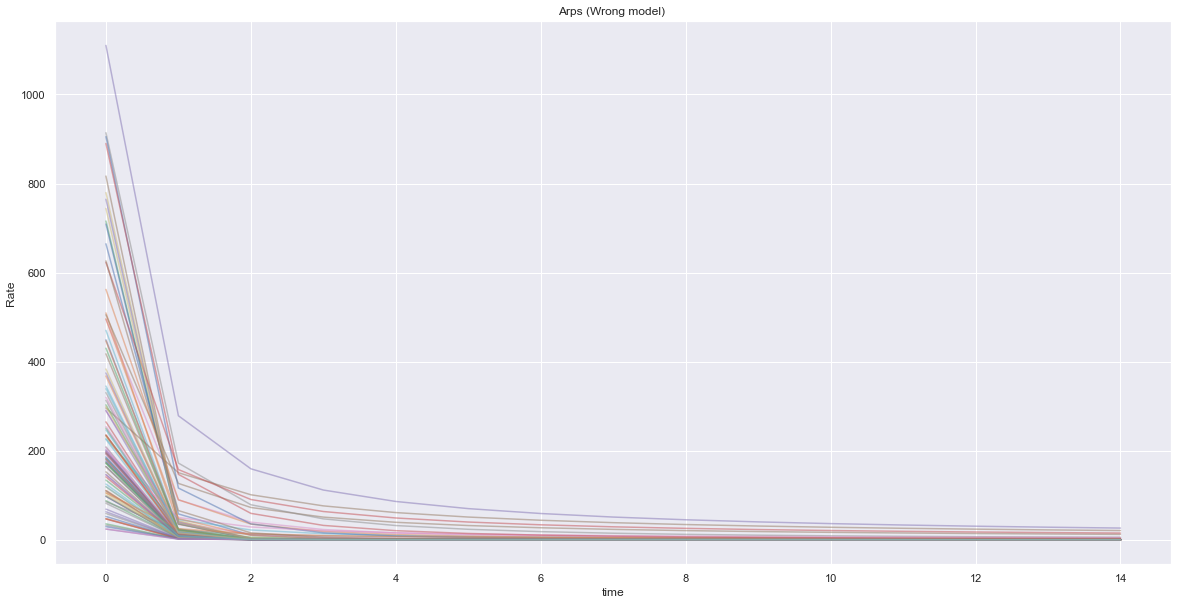

In [83]:
plt.figure(figsize=(20,10))
plt.plot(ARP_Mdl,alpha = 0.5)
# plt.plot(QS_DF,color = 'blue',alpha = 0.1)
plt.title('Arps (Wrong model) ')
plt.xlabel('time')
plt.ylabel('Rate ')
plt.show()

In [26]:
ARP_DF = pd.DataFrame(ARP_Mdl,columns=['realization'+str(i) for i in range(N)])

In [27]:
Mismatch = QS_DF - ARP_DF 

In [28]:
Mismatch.head(5)

realization0  realization1  realization2  realization3  realization4  \
0    601.947270    102.276035    417.835145     71.815455    474.533149   
1    170.729665     51.792721    106.768138     12.102651    165.180204   
2    121.604103     38.014837     57.966228     10.200856    114.578536   
3     89.107675     28.606883     33.950874      8.263389     82.603348   
4     69.087554     22.603748     21.474307      6.982564     63.025479   

   realization5  realization6  realization7  realization8  realization9  ...  \
0    725.408871    671.618554    247.545492    169.400998    801.866066  ...   
1     16.829397    -12.500553      2.430145     22.655416     39.322271  ...   
2      1.110706     -0.630779      0.133600      3.869184      2.049260  ...   
3      0.095777     -0.031479      0.012559      0.700123      0.109068  ...   
4      0.009151     -0.001572      0.001326      0.133104      0.005876  ...   

   realization90  realization91  realization92  realization93  realization94  \
0     206.839406      64.090904     549.342680     461.584192     460.958384   
1      13.315355      33.637772     262.229983     280.720245     160.586243   
2       3.886211      36.434004     178.361121     292.409828      86.438442   
3       1.390816      35.949931     127.304309     276.770283      50.912988   
4       0.567834      34.877196      95.827406     259.403720      31.998963   

   realization95  realization96  realization97  realization98  realization99  
0     388.312644      86.382809      90.325995     825.097767     142.222964  
1     271.585767      17.226322      82.758209      91.738521      83.422661  
2     244.438811       6.017284      63.949992      49.327836      63.037953  
3     211.683592       2.360572      49.529831      28.845644      48.672389  
4     185.952724       1.008827      40.006668      18.443866      39.297967  

[5 rows x 100 columns]

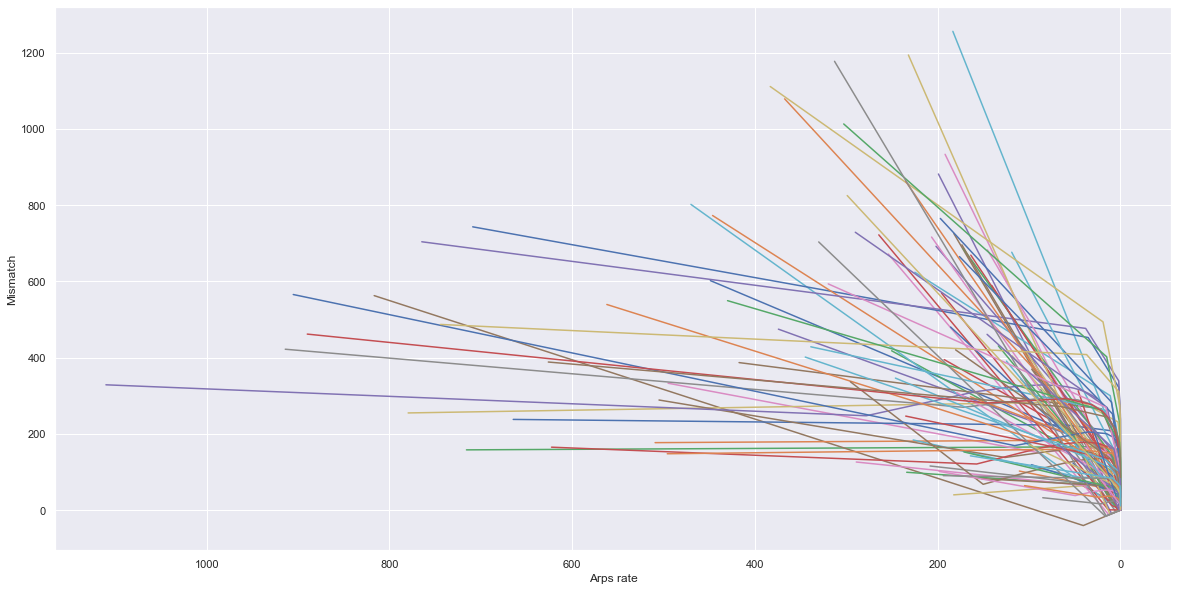

In [29]:
plt.figure(figsize=(20,10))
plt.plot(ARP_DF,Mismatch)
plt.xlabel('Arps rate')
plt.ylabel('Mismatch')
plt.gca().invert_xaxis()
plt.show()

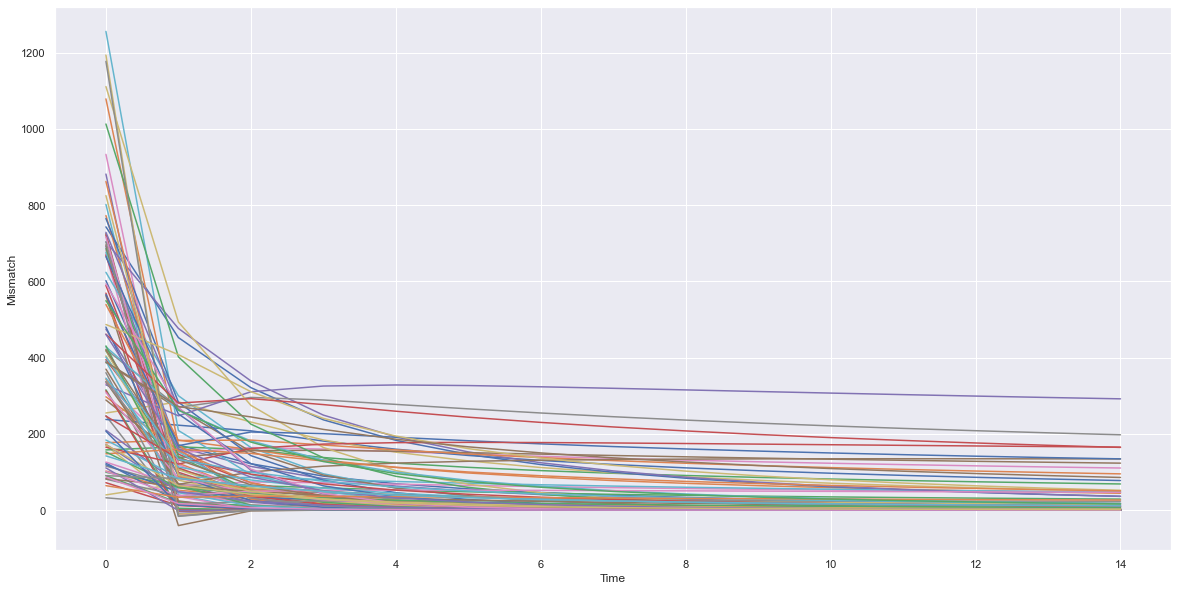

In [30]:
plt.figure(figsize=(20,10))
plt.plot(T,Mismatch)
plt.xlabel('Time')
plt.ylabel('Mismatch')
# plt.gca().invert_xaxis()
plt.show()

In [31]:
# @cuda.jit 
def M_A(matX,matY,win_size):
    mn_range=np.min(matX); mx_range=np.max(matX)
    flt_X=matX.flatten()
    flt_Y=matY.flatten()
    save_mat=list()
    for p in tqdm(flt_X):
        lstX=list()
        lstY=list()
        for j in range(len(flt_X)):
            if (flt_X[j]>= (p/2-win_size))& (flt_X[j]<=p/2+win_size):
                lstY.append(flt_Y[j])
                lstX.append(flt_X[j])
        if len(lstY)==0:
            print( "Not in range")
            return
#         CrCo_M=np.corrcoef(lstX,lstY)   
        mu=np.mean(lstY)
        sd=np.std(lstY)
#         PC=np.percentile(lstY,[10,50,90])
#         dic={'x':p,'mean':mu, 'STD': sd, 'P10':PC[0], 'P50':PC[1], 'P90':PC[2],'Cor_Coef':CrCo_M[0,1]}
        dic={'x':p,'mean':mu, 'STD': sd} 
        save_mat.append(dic)    
    df= pd.DataFrame.from_dict(save_mat)
    df.sort_values(by=['x'],ascending=False, inplace=True)
    fig1 = go.Figure([
    go.Scatter(
        name='ave',
        x=df['x'],
        y=df['mean'],
        line=dict(color='rgb(0,100,80)'),
        mode='lines'
    ),
#     go.Scatter(
#         name='P10',
#         x=df['x'], 
#         y=df['P10'], 
#         line=dict(color='rgba(255,255,255)'),
        
#     ),
#         go.Scatter(
#         name='P90',   
#         x=df['x'], 
#         y=df['P90'], 
#         line=dict(color='rgba(255,0,255)'),
        
#     ),
#       go.Scatter(
#         name='P50' ,   
#         x=df['x'], 
#         y=df['P50'], 
#         line=dict(color='rgba(255,255,0)'),
        
#     ),
    
        go.Scatter(
        name='STD' ,   
        x=df['x'], 
        y=df['STD'],
        line=dict(color='rgba(255,255,0)'),
        
    )])
    fig1.update_layout(
    xaxis=dict(visible=True,autorange='reversed'),    
    title="",
    xaxis_title="Arps rate(model)",
    yaxis_title="Mismatch",
    legend_title="window size{}".format(win_size),
    font=dict(
        family="Courier New, monospace",
        size=12
    ))
    fig1.show() 
#     fig2 = go.Figure([
#     go.Scatter(
#         name='Cor_Coef',
#         x=df['x'],
#         y=df['Cor_Coef'],
#         line=dict(color='rgb(0,100,80)'),
#         mode='lines'
#     )])
    
#     fig2.update_layout(
#     xaxis=dict(visible=True,autorange='reversed'),    
#     title="",
#     xaxis_title="Arps rate(model)",
#     yaxis_title="Correlation coefficients(Peasron) of Mismatch",
#     legend_title="window size {}".format(win_size),
#     font=dict(
#         family="Courier New, monospace",
#         size=12
#     )),

#     fig2.show()
    return df

In [32]:
df_out=M_A(np.array(ARP_DF),np.array(Mismatch),win_size=100)  
# df_out=M_A(np.array(T),np.array(Mismatch),win_size=1)  

  0%|          | 0/1500 [00:00<?, ?it/s]

In [33]:
df_out

x        mean         STD
54    1.110245e+03  355.026407  209.320267
47    9.140030e+02  560.249152  310.635126
70    9.052525e+02  560.249152  310.635126
93    8.899025e+02  548.023601  301.438420
15    8.166875e+02  615.605352  296.518702
...            ...         ...         ...
1432  2.221891e-17   45.117052   72.191307
1437  2.023899e-17   45.117052   72.191307
1490  1.824042e-17   45.117052   72.191307
1496  1.494272e-17   45.117052   72.191307
1464  1.481056e-17   45.117052   72.191307

[1500 rows x 3 columns]

In [34]:
# print('totlal',len(df_out))
# print('more than 800is',len(df_out[df_out['x']>800]))
# print('less than 300is',len(df_out[df_out['x']<300]))

In [35]:
# lst_size=np.arange(100,990,100)
# for i in lst_size:
#     M_A(np.array(ARP_DF),np.array(Mismatch),win_size=i)  

In [36]:
def M_A1(matX,matY,win_size):
    mn_range=np.min(matX); mx_range=np.max(matX)
    flt_X=matX.flatten()
    flt_Y=matY.flatten()
    
    save_mat=[]
    for p in tqdm(flt_X):
        lstX=[]
        lstY=[]
        
        for j in range(len(flt_X)):
            if (flt_X[j]>= (p/2-win_size))& (flt_X[j]<=p/2+win_size):
                lstY.append(flt_Y[j])
                lstX.append(flt_X[j])
        if len(lstY)==0:
            print( "Not in range")
            return
#         CrCo_M=np.corrcoef(lstX,lstY)   
        mu=np.mean(lstY)
        sd=np.std(lstY)
#         PC=np.percentile(lstY,[10,50,90])
#         dic={'x':p,'mean':mu, 'STD': sd, 'P10':PC[0], 'P50':PC[1], 'P90':PC[2],'Cor_Coef':CrCo_M[0,1]}
        dic={'x':p,'mean':mu, 'STD': sd}
        save_mat.append(dic)
    df= pd.DataFrame.from_dict(save_mat)
    df.sort_values(by=['x'],ascending=False, inplace=True)    
    return df

In [37]:
def MA_CV(matX,matY,win_size,K=.5):
    mn_range=np.min(matX); mx_range=np.max(matX)
    matX=matX.flatten()
    matY=matY.flatten()    
    flt_X, X_test, flt_Y, y_test = train_test_split(matX, matY, test_size=K, random_state=77)
    trn=M_A1(flt_X,flt_Y,win_size)
    tst=M_A1(X_test,y_test,win_size)
#     score=1-(trn.div(tst))
    return trn,tst

In [38]:
trng,tst=MA_CV(np.array(ARP_DF),np.array(Mismatch),win_size=100,K=.2)  

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [39]:
ARP_DF

realization0  realization1  realization2  realization3  realization4  \
0   4.487753e+02  1.106330e+02  2.503975e+02  4.707135e+01  3.743378e+02   
1   2.235326e+01  5.510573e+00  1.247217e+01  2.344599e+00  1.864557e+01   
2   1.114406e+00  2.747257e-01  6.217912e-01  1.168884e-01  9.295619e-01   
3   5.560790e-02  1.370857e-02  3.102684e-02  5.832630e-03  4.638434e-02   
4   2.777280e-03  6.846608e-04  1.549604e-03  2.913049e-04  2.316619e-03   
5   1.388330e-04  3.422540e-05  7.746289e-05  1.456201e-05  1.158052e-04   
6   6.946330e-06  1.712424e-06  3.875756e-06  7.285920e-07  5.794165e-06   
7   3.478625e-07  8.575580e-08  1.940925e-07  3.648691e-08  2.901639e-07   
8   1.743609e-08  4.298382e-09  9.728596e-09  1.828854e-09  1.454404e-08   
9   8.747411e-10  2.156430e-10  4.880683e-10  9.175087e-11  7.296520e-10   
10  4.392368e-11  1.082816e-11  2.450755e-11  4.607126e-12  3.663830e-11   
11  2.207529e-12  5.442048e-13  1.231707e-12  2.315467e-13  1.841380e-12   
12  1.110459e-13  2.737527e-14  6.195888e-14  1.164757e-14  9.262750e-14   
13  5.590963e-15  1.378296e-15  3.119519e-15  5.864358e-16  4.663634e-15   
14  2.817465e-16  6.945676e-17  1.572026e-16  2.955244e-17  2.350157e-16   

    realization5  realization6  realization7  realization8  realization9  ...  \
0   1.823535e+02  2.540472e+02  5.862183e+01  4.660624e+01  4.700644e+02  ...   
1   9.082931e+00  1.265396e+01  2.919922e+00  2.321432e+00  2.341366e+01  ...   
2   4.528231e-01  6.308540e-01  1.455707e-01  1.157334e-01  1.167272e+00  ...   
3   2.259548e-02  3.147907e-02  7.263850e-03  5.774994e-03  5.824583e-02  ...   
4   1.128508e-03  1.572190e-03  3.627856e-04  2.884262e-04  2.909029e-03  ...   
5   5.641281e-05  7.859195e-05  1.813523e-05  1.441809e-05  1.454190e-04  ...   
6   2.822543e-06  3.932247e-06  9.073729e-07  7.213907e-07  7.275851e-06  ...   
7   1.413490e-07  1.969215e-07  4.543997e-08  3.612624e-08  3.643645e-07  ...   
8   7.084908e-09  9.870394e-09  2.277611e-09  1.810774e-09  1.826323e-08  ...   
9   3.554386e-10  4.951821e-10  1.142641e-10  9.084367e-11  9.162373e-10  ...   
10  1.784777e-11  2.486475e-11  5.737585e-12  4.561565e-12  4.600734e-11  ...   
11  8.969983e-13  1.249660e-12  2.883612e-13  2.292565e-13  2.312251e-12  ...   
12  4.512193e-14  6.286196e-14  1.450551e-14  1.153235e-14  1.163137e-13  ...   
13  2.271809e-15  3.164988e-15  7.303264e-16  5.806330e-16  5.856188e-15  ...   
14  1.144837e-16  1.594939e-16  3.680349e-17  2.925996e-17  2.951121e-16  ...   

    realization90  realization91  realization92  realization93  realization94  \
0    2.905395e+01     104.957008   4.299974e+02     889.902496   1.459683e+02   
1    1.447162e+00      24.519377   2.141794e+01     146.547904   7.270605e+00   
2    7.214723e-02      13.334069   1.067776e+00      58.919524   3.624709e-01   
3    3.600084e-03       9.016282   5.328111e-02      31.871326   1.808698e-02   
4    1.798025e-04       6.754303   2.661071e-03      20.034815   9.033358e-04   
5    8.988120e-06       5.371506   1.330238e-04      13.794252   4.515671e-05   
6    4.497090e-07       4.442719   6.655677e-06      10.096045   2.259358e-06   
7    2.252080e-08       3.777878   3.333070e-07       7.720828   1.131455e-07   
8    1.128822e-09       3.279576   1.670652e-08       6.102824   5.671249e-09   
9    5.663120e-11       2.892865   8.381396e-10       4.949935   2.845176e-10   
10   2.843642e-12       2.584456   4.208580e-11       4.098771   1.428658e-11   
11   1.429166e-13       2.333031   2.115160e-12       3.452043   7.180193e-13   
12   7.189169e-15       2.124325   1.063994e-13       2.948836   3.611870e-14   
13   3.619619e-16       1.948440   5.357022e-15       2.549405   1.818512e-15   
14   1.824042e-17       1.798297   2.699575e-16       2.226908   9.164066e-17   

    realization95  realization96  realization97  realization98  realization99  
0      626.131416   2.380126e+01   1.939402e+02   2.990384e+02   1.642436e+02  
1       65.225570   1.185528e+00 

In [40]:
tst.reset_index(drop=True,inplace=True)
tst

x        mean         STD
0    1.110245e+03  567.281380  234.584687
1    8.899025e+02  507.130700  209.577811
2    7.645854e+02  580.085796  176.619455
3    7.441374e+02  580.085796  176.619455
4    4.950740e+02  591.554188  194.126170
..            ...         ...         ...
295  1.031141e-16   46.776925   70.942809
296  9.553399e-17   46.776925   70.942809
297  8.390583e-17   46.776925   70.942809
298  7.835873e-17   46.776925   70.942809
299  7.448513e-17   46.776925   70.942809

[300 rows x 3 columns]

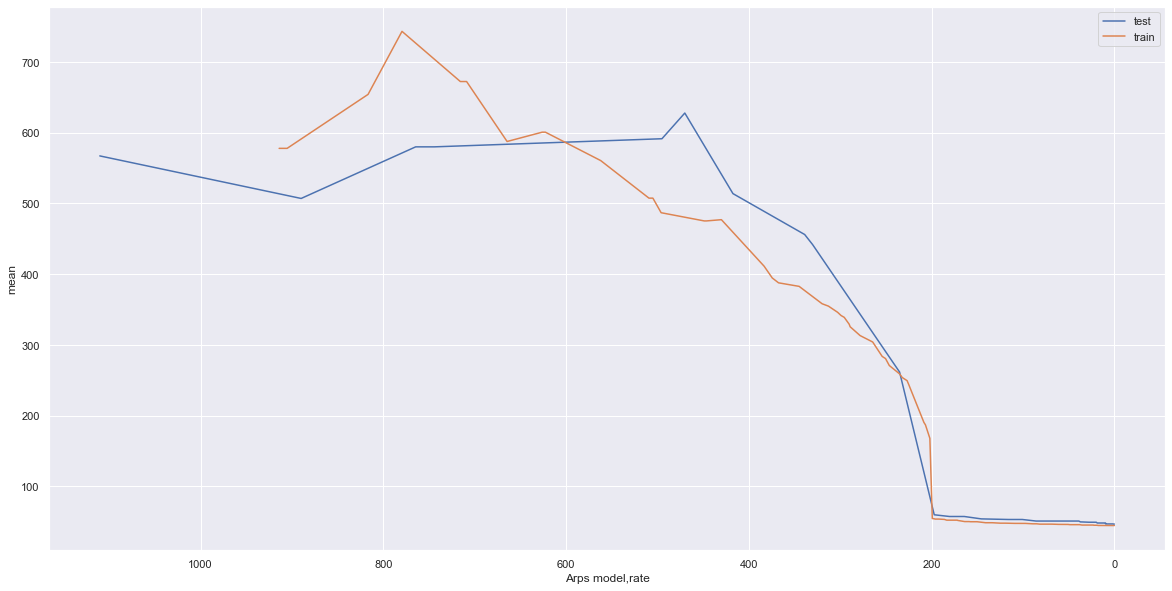

In [41]:
plt.figure(figsize=(20,10))
plt.plot(tst['x'],tst['mean'],label='test')
plt.plot(trng['x'],trng['mean'],label='train')
plt.legend()
plt.xlabel('Arps model,rate')
plt.ylabel('mean')
plt.gca().invert_xaxis()
plt.show()

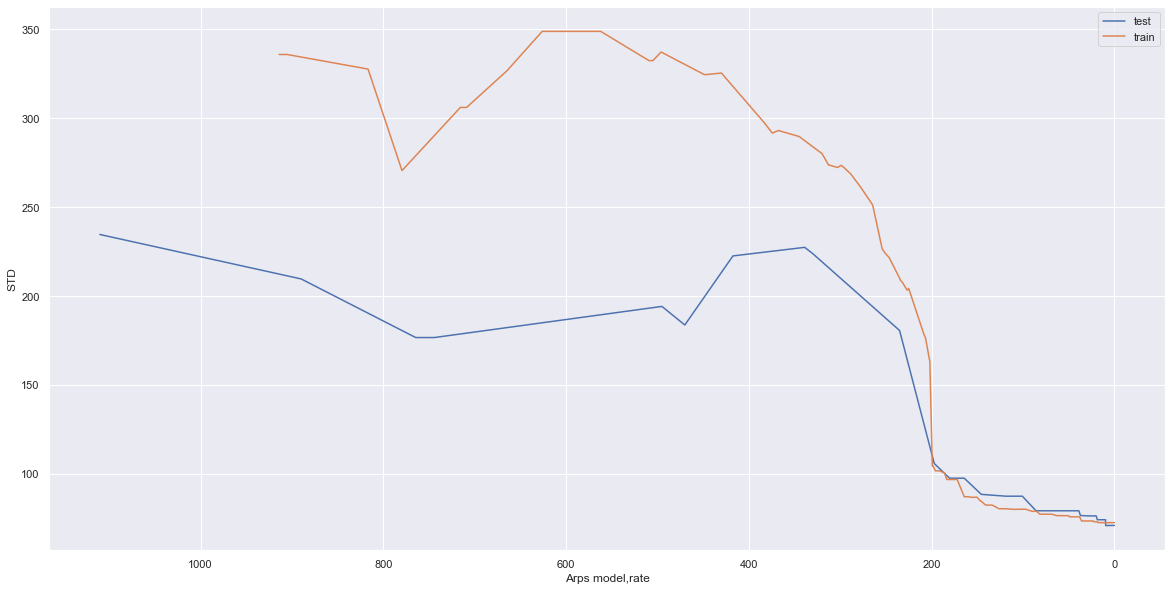

In [42]:

plt.figure(figsize=(20,10))
plt.plot(tst['x'],tst['STD'],label='test')
plt.plot(trng['x'],trng['STD'],label='train')
plt.legend()
plt.xlabel('Arps model,rate')
plt.ylabel('STD')
plt.gca().invert_xaxis()
plt.show()

In [43]:
# plt.figure(figsize=(20,10))
# plt.plot(tst['x'],tst['Cor_Coef'],label='test')
# plt.plot(trng['x'],trng['Cor_Coef'],label='train')
# plt.legend()
# plt.xlabel('Arps model,rate')
# plt.ylabel('Cor_Coef')
# plt.gca().invert_xaxis()
# plt.show()


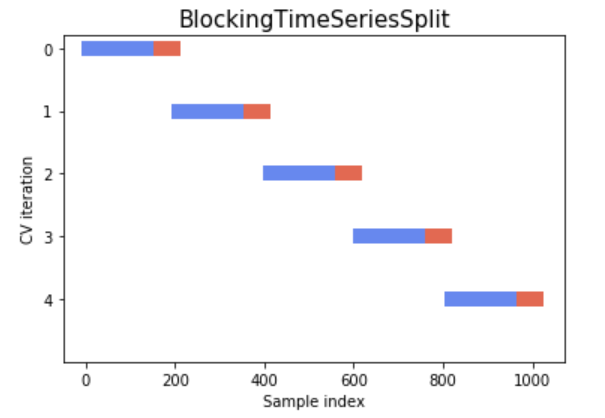

In [44]:
sft=df_out-df_out.shift(1)

In [45]:
# df_out['x']

In [46]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['mean'],label='shifted-mean',alpha=.5)
# plt.scatter(df_out['x'],sft['P50'],label='shifted-P50',alpha=.5)
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in mean')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()


In [47]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['STD'],label='shifted-STD')
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in STD')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

In [48]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['P10'],label='shifted-P10')
# plt.scatter(df_out['x'],sft['P90'],label='shifted-P90')
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in shifted precentiles')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

In [49]:
# plt.figure(figsize=(20,10))
# plt.scatter(df_out['x'],sft['Cor_Coef'],label='shifted-Cor_Coef')
# plt.xlabel('Arps model,rate')
# plt.ylabel('error in shifted Cor_Coef')
# plt.legend()
# plt.gca().invert_xaxis()
# plt.show()

### Generating _Truth_ and _Observation_ with SEM Model

In [50]:
# def obsv(df,obs_num, sd ,percent=1,mu=0):
#     rnd=random.randint(0,N-1)
#     tr = df['realization'+str(rnd)]
#     d = tr + np.random.normal(mu, sd,len(tr+0))    # adding noise to 15 y as observation
#     prop = len(d)*percent/obs_num
#     intr = np.arange(0,len(d)*percent,prop )+1
#     obs_mat=np.zeros(int(obs_num));idx=[]
#     for count,inx in enumerate(intr):
#         obs_mat[count]=d[int(inx)]
#         idx.append(int(inx))
#     return obs_mat,idx,prop,tr

In [51]:
def obsv1(df, sd ,mu=0):
#     rnd=random.randint(0,N-1)
    tr = df['realization'+str(45)]
    obs_mat = tr + np.random.normal(mu, sd,len(tr+0))    # adding noise to 15 y as observation
    obs_mat = np.where(obs_mat<0,0,obs_mat)
    return obs_mat,tr

In [52]:
# obs_SEM, indx,_, tr=obsv(QS_DF,11 , sd=10)
# indx
obs_SEM,tr=obsv1(QS_DF, sd=50)
obs_SEM
tr

0     793.661882
1     264.119156
2     228.069516
3     207.450703
4     193.123028
5     182.216931
6     173.457437
7     166.167127
8     159.943494
9     154.528167
10    149.745603
11    145.471216
12    141.613466
13    138.103175
14    134.886826
Name: realization45, dtype: float64

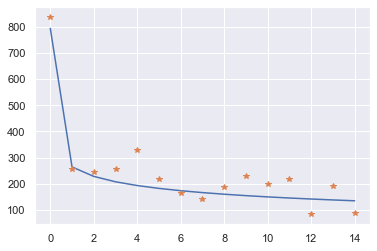

In [53]:
plt.plot(tr)
plt.plot(obs_SEM,'*')
    

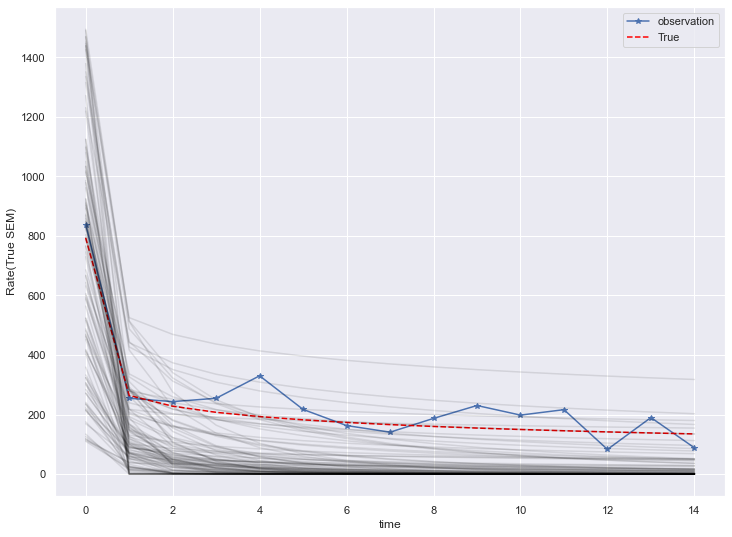

In [54]:
# rnd=random.randint(0,N-1)
# tr = QS_DF['realization'+str(rnd)]
# obs_SEM = tr + ss.norm.rvs(0,20,prod_time)
plt.figure(figsize=(12,9))
plt.plot(T,obs_SEM, 'b-*',label='observation')
plt.plot(T,tr,label='True', color='red',linestyle='--')
plt.plot(QS_DF,alpha=.1,color='black')
plt.ylabel('Rate(True SEM)')
plt.xlabel('time')
plt.legend()
plt.show()

In [55]:
# fig_stats = go.Figure()
# fig_stats.add_trace(go.Scatter(x=T, y=Tru_SEM, mode='lines', name='Truth', line=dict(color='red')))
# fig_stats.add_trace(go.Scatter(x=np.asarray(obs_SEM)[:,0], y=np.asarray(obs_SEM)[:,1], mode='markers', name='measurment', line=dict(color='blue')))
# fig_stats.update_layout(legend=dict(x=0.8,y=0.9,traceorder='normal',font=dict(size=15,)))
# fig_stats.show()

# EnKF V3

In [56]:
def EnKF(mf_k,Xf_k, gf_k, d, par1, par2, FM, pa_up,tme ,st_df=0, r=.5):
    np.random.seed(1366)
    random.seed(586)
    R = r * np.eye(1)
    N=mf_k.shape[1]
    nobs=(obs_SEM).shape[0]
    Y_f_ = np.zeros([5,N,nobs+1])
    P_f_ = np.zeros([5,5,nobs+1])
    Y_a_ = np.zeros([5,N,nobs+1])
    P_a_ = np.zeros([5,5,nobs+1])
    Y_f_[0,:,0] = mf_k
    Y_f_[3,:,0] = mf_k
    Y_f_[4,:,0] = mf_k
    Y_f_[1,:,0] = par1; Y_f_[2,:,0] = par2
    P_f_[:,:,0] = np.cov(Y_f_[:,:,0])
    Y_a_[0,:,0] = mf_k
    Y_a_[3,:,0] = mf_k
    Y_a_[4,:,0] = mf_k
    Y_a_[1,:,0] = par1; Y_a_[2,:,0] = par2
    P_a_[:,:,0] = np.cov(Y_a_[:,:,0])
    for t in tqdm(range(nobs)):
        Q0 = Y_a_[0,:,t]

        if FM=='Arps':
            Qt=ArpsRate(np.array([range(tme)]).T, Q0 ,Y_f_[1,:,0] , Y_f_[2,:,0])  #Arps(time, Q, Di0, b)
        else:
            
            Qt=SEM(np.array(([range(tme)])*N).T, Q0 ,Y_f_[1,:,0],Y_f_[2,:,0])     #SEM(time, Q, Tau, n)
        Y_f_[0,:,t+1] = np.abs(Q0)
        Y_f_[3,:,t+1] = Qt[t,:]
        Y_f_[4,:,t+1] = Qt[t,:]
        Y_a_[1,:,t] = np.where(Y_a_[1,:,t]<=0,10**-6,Y_a_[1,:,t])
        Y_a_[2,:,t] = np.where(Y_a_[2,:,t]<=0,10**-6,Y_a_[2,:,t])
        if pa_up== True:

            Y_f_[1,:,t+1] = Y_a_[1,:,t];Y_f_[2,:,t+1] = Y_a_[2,:,t]
             
        else:
            Y_f_[1,:,t+1] = Y_a_[1,:,0];Y_f_[2,:,t+1] = Y_a_[2,:,0]
            
        Y_f_now = Y_f_[:,:,t+1]
        P_f_now = np.cov(Y_f_now)*N/np.sqrt(N-1)
        P_f_[:,:,t+1] = P_f_now
        H = np.array([Qt[t,:] @  sla.pinv(Y_f_now)])   
        K = P_f_now @ H.T @ sla.pinv(H @ P_f_now @ H.T + R)
        y = d[t] + ss.norm.rvs(0,r,1) # measurement + noise
        Y_a_now = Y_f_now + K @ (y - H @ Y_f_now)
#         print("iteration", t)
#         print('p1',Y_f_now[1,2:4])
#         print('p2',Y_f_now[2,2:4])

#         print(np.min(Y_a_now[1,:]))

        Y_a_now[1,:] = np.where(Y_a_now[1,:]<=0,10**-5, Y_a_now[1,:])
        Y_a_now[2,:] = np.where(Y_a_now[2,:]<=0,10**-5, Y_a_now[2,:])
        P_a_now = np.cov(Y_a_now)
        Y_a_[:,:,t+1] = Y_a_now
        P_a_[:,:,t+1] = P_a_now
        
    return Y_a_

In [57]:
Arps_updated= EnKF(mf_k=np.matrix(para_mat[0,:]),                      #state_variables,, 
                    Xf_k=np.array(ARP_DF),                            #dynamic_reservoir_model
                    gf_k=np.array(ARP_DF),                           #observation_current
                    d=np.asarray(obs_SEM),                            #measurements
                    par1=(para_mat[1,:]),                             #paramter1
                    par2=(para_mat[2,:]),                             #parameter2                                                    
                    r=50,                                             # measurements error (STD)
                    FM='Arps',                                        #forward model
                    st_df= df_out,                                     #statistical data
                   pa_up=True,                                        #updating parameters
                  tme=prod_time)



# print("RMSE Arps_updated/measurment is ",RMSE ( (np.array(obs_SEM) * np.ones((N,len(T)))),Arps_updated[4,:,1:]))
# print("RMSE Arps_updated/true is ",RMSE ( (np.array(tr) * np.ones((N,len(T)))),Arps_updated[4,:,1:]))

  0%|          | 0/15 [00:00<?, ?it/s]

In [58]:
# q0=Arps_updated[0,:,-1]
# D=Arps_updated[1,:,-1]
# B=Arps_updated[2,:,-1]
# aP=ArpsRate(np.array([range(prod_time)]).T, q0, D, B)
# # plt.plot(aP)
# plt.show()

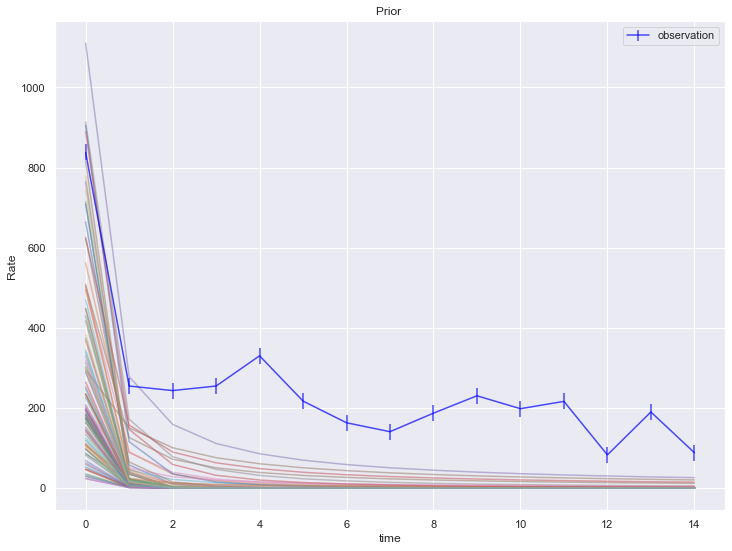

In [87]:
plt.figure(figsize=(12,9))
plt.errorbar(T,np.asarray(obs_SEM), yerr = 20,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--')
# plt.plot(aP)
plt.plot(T,ARP_DF,alpha=.5)
plt.ylabel('Rate')
plt.xlabel('time')
plt.title('Prior ')
plt.legend()
plt.show()

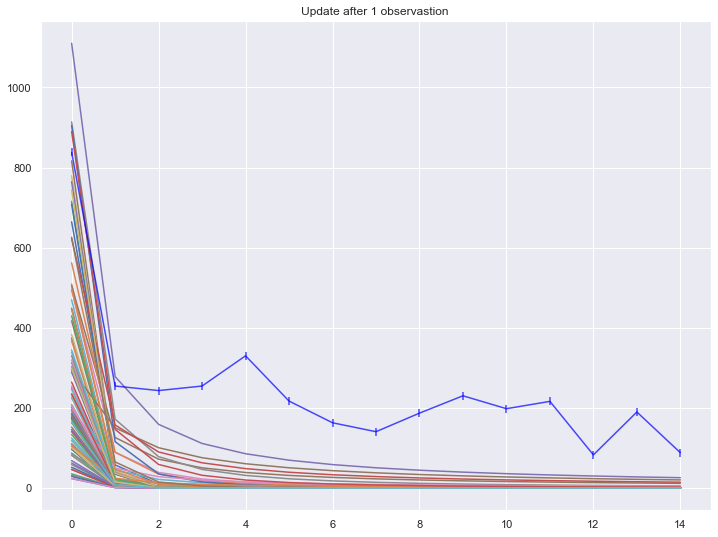

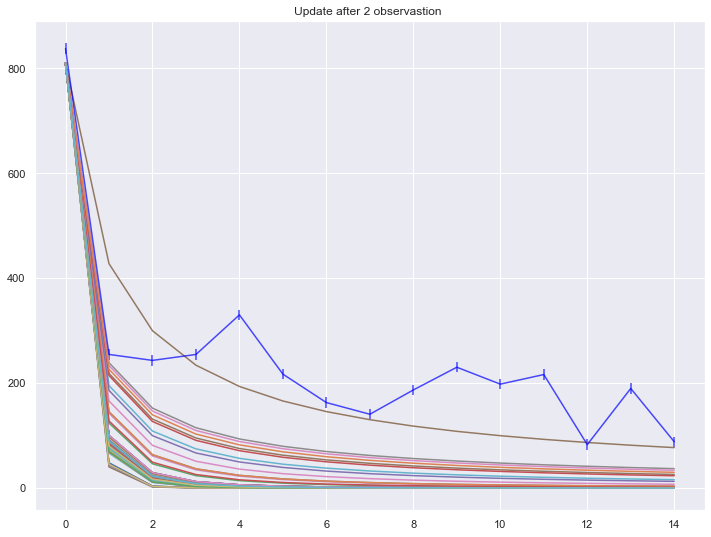

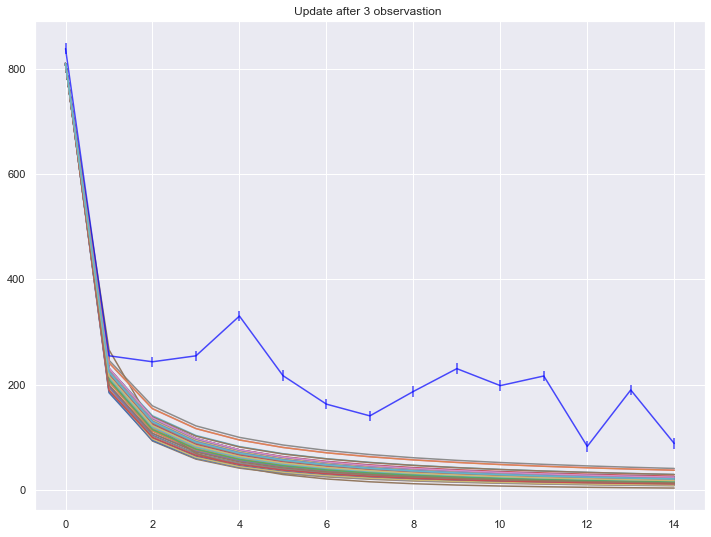

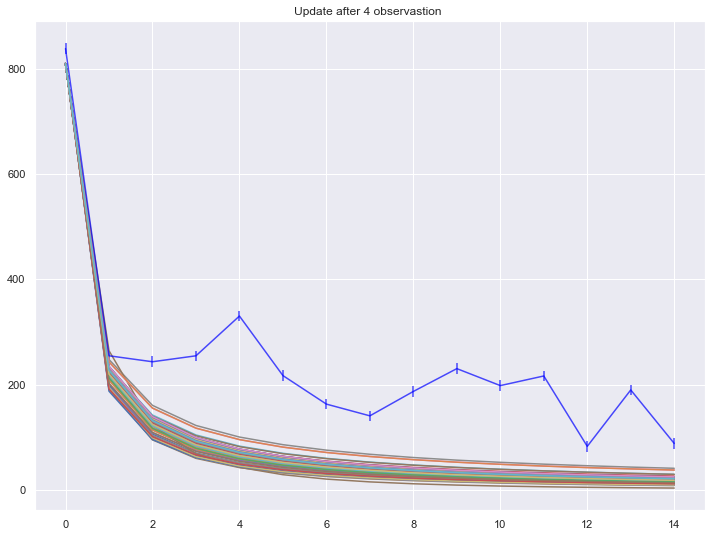

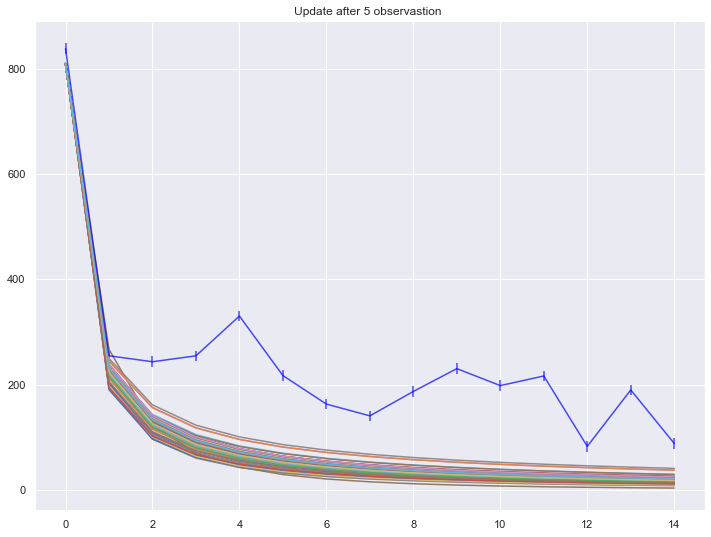

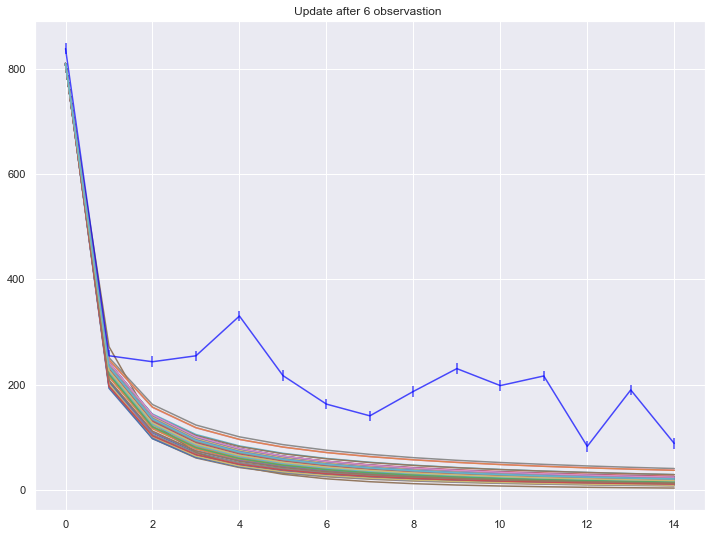

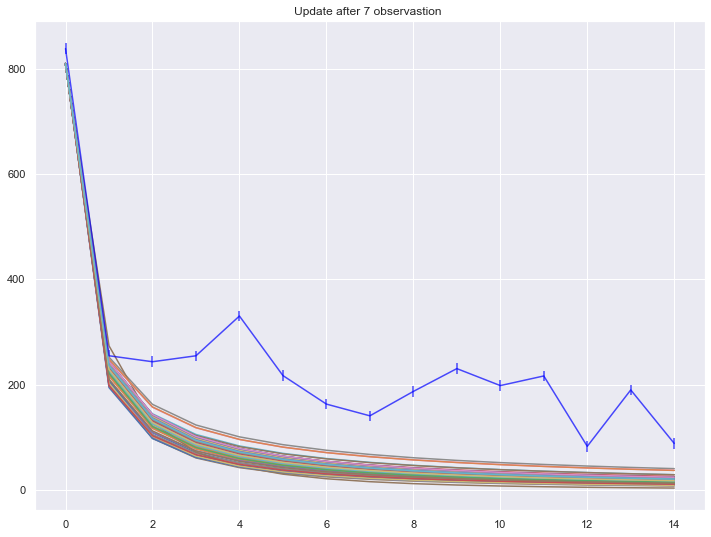

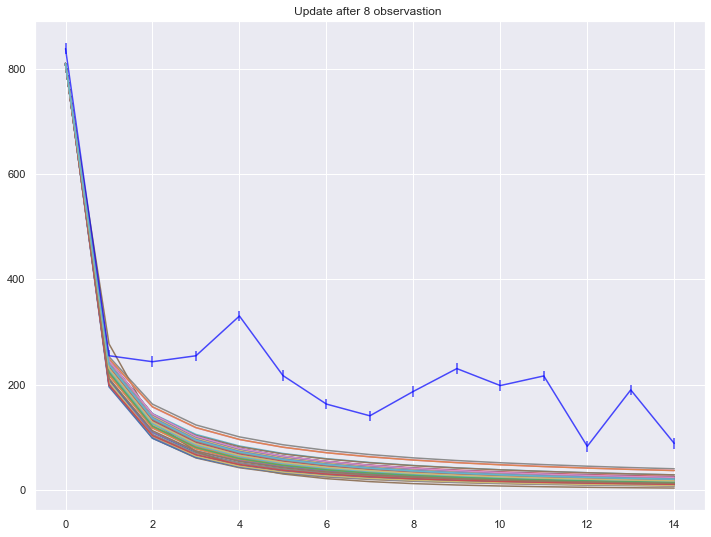

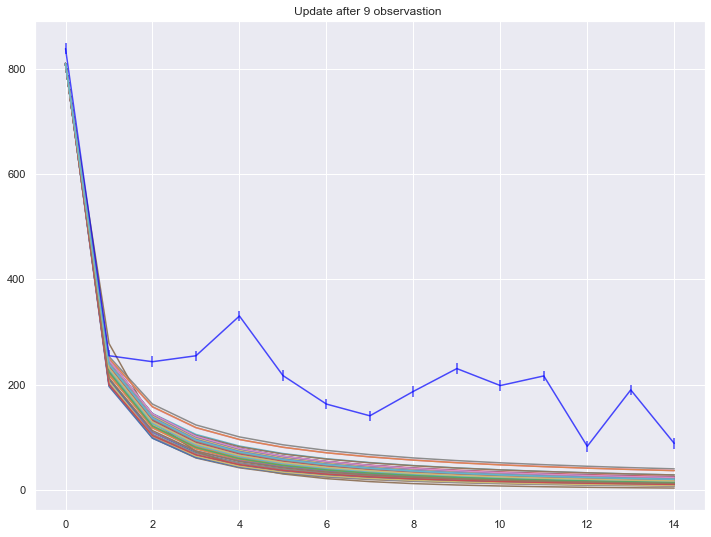

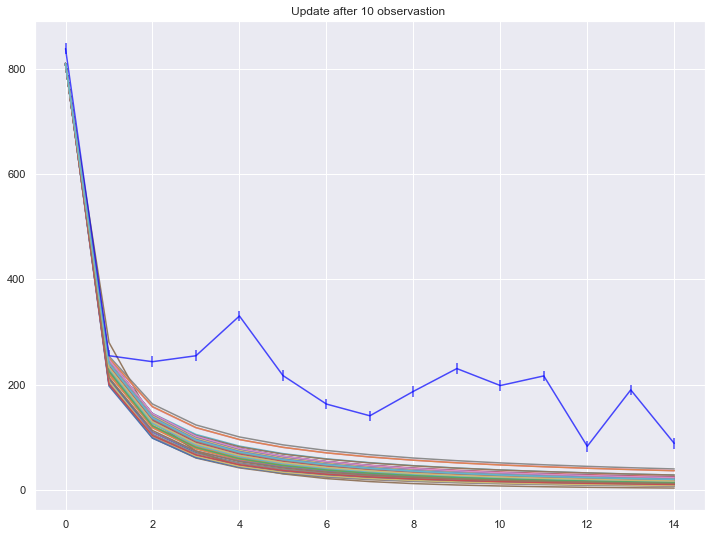

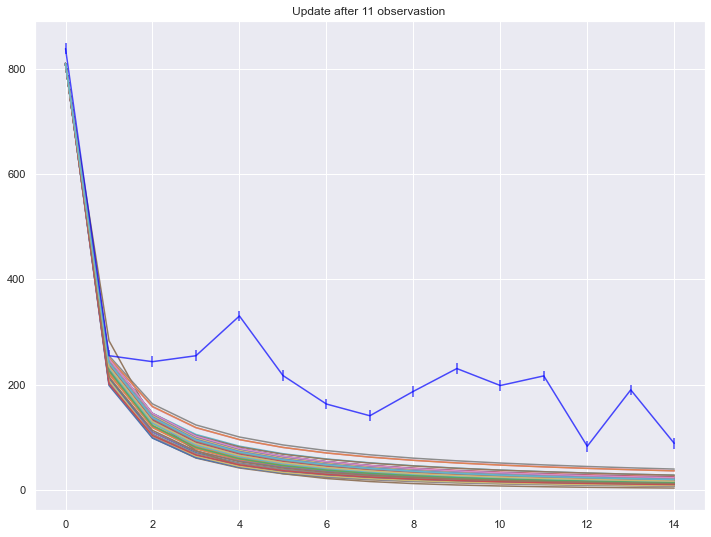

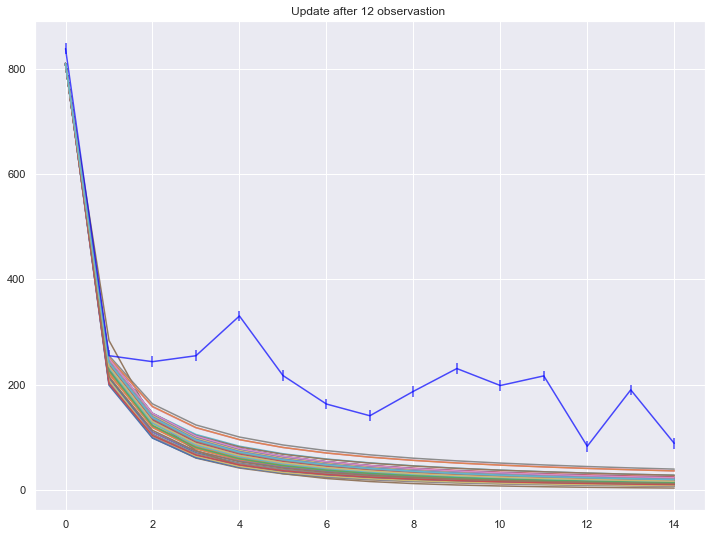

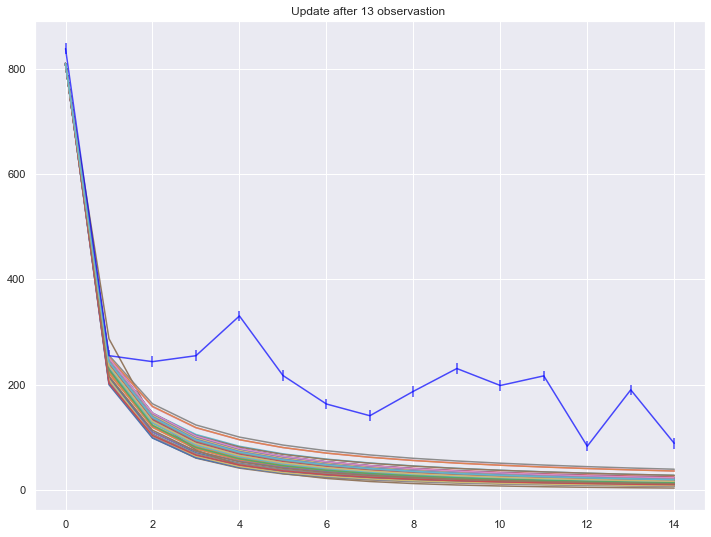

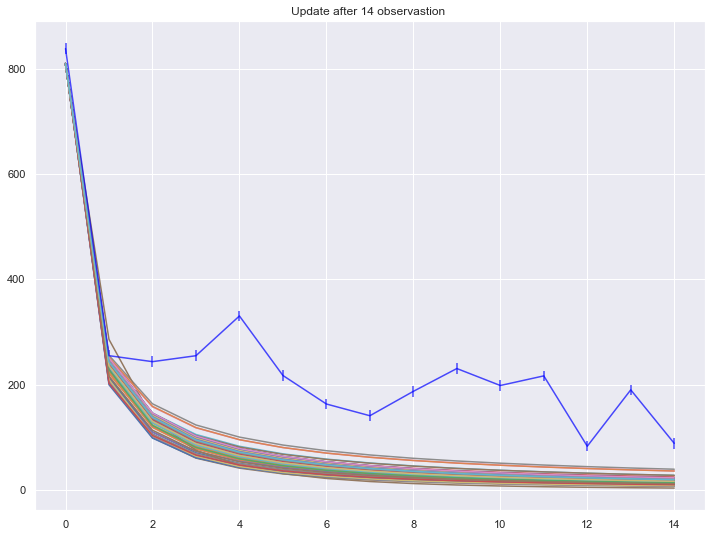

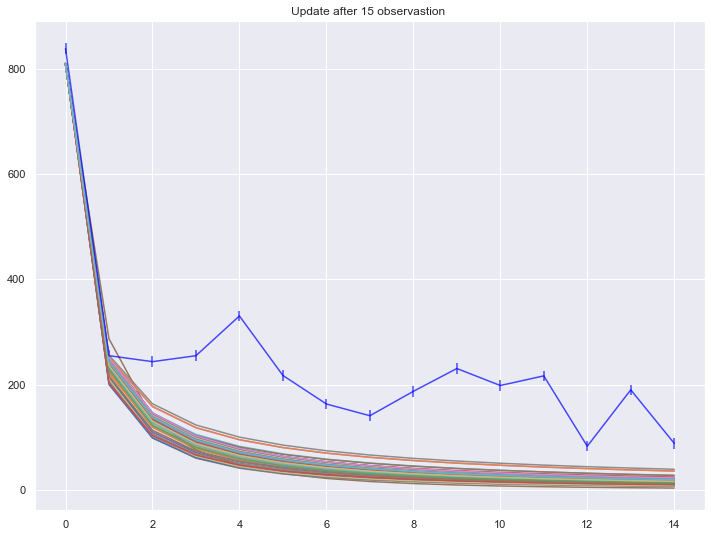

array([[809.56078637, 809.53038332, 809.54294982, ..., 809.53787363,
        809.54732322, 809.53520355],
       [227.58404446, 246.18825585, 238.67596433, ..., 241.73970197,
        236.00395826, 243.33525647],
       [121.3111612 , 140.9991866 , 132.97648131, ..., 136.23701083,
        130.14605256, 137.94131007],
       ...,
       [ 15.66520778,  24.21585912,  20.50785827, ...,  21.97823563,
         19.27250456,  22.76681726],
       [ 14.18737659,  22.25706549,  18.74512049, ...,  20.13571929,
         17.5790463 ,  20.88264275],
       [ 12.9396381 ,  20.58035718,  17.24398858, ...,  18.56325477,
         16.13972964,  19.27286836]])

In [61]:
plotter(Arps_updated,FM='Arps',tme=prod_time,trp=False)

In [ ]:
# plt.figure(figsize=(12,9))
# plt.errorbar(indx,np.asarray(obs_SEM), yerr = 20,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=5,alpha=0.4)
# # plt.plot(aP)
# plt.plot(indx,Arps_updated[3,:,1:].T,alpha=.5)
# plt.ylabel('Rate')
# plt.xlabel('time')
# plt.title('Posteroir and likelyhood')
# plt.legend()
# plt.show()

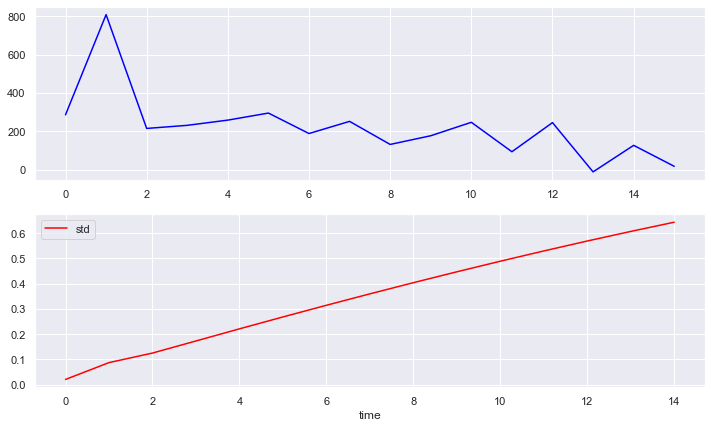

In [62]:

fig = plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
plt.plot(Arps_updated[4,:,:].mean(axis=0),label='mean',color = "blue")

plt.subplot(2, 1, 2)
plt.plot(Arps_updated[4,:,1:].std(axis=0),label='std',color = 'red')
plt.legend()
plt.xlabel('time')
plt.show()




In [63]:
SEM_update= EnKF(mf_k=np.matrix(SEM_par[0,:]),                      #state_variables,, 
                    Xf_k=np.array(QS_DF),                            #dynamic_reservoir_model
                    gf_k=np.array(QS_DF),                           #observation_current
                    d=np.asarray(obs_SEM).T,                        #measurements
                    par1=(SEM_par[1,:]),                            #paramter 1
                    par2=(SEM_par[2,:]),                            #paramter 2
                    r=50,                                           #R measurments error
                    FM='SEM',                                       #foreward model
                    pa_up=False,                                    # updating paramter
                    tme = prod_time)


  0%|          | 0/15 [00:00<?, ?it/s]

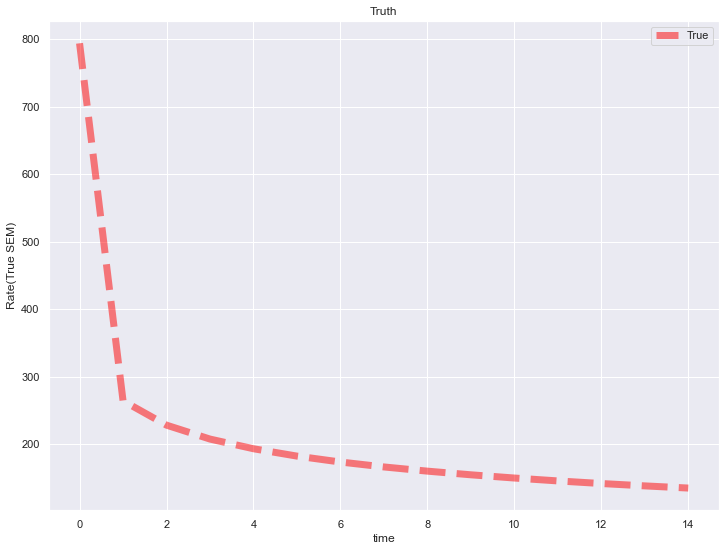

In [86]:
plt.figure(figsize=(12,9))
# plt.errorbar(T,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7,)
plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=7,alpha=.5)
# plt.plot(T,QS_DF,alpha=.5)
plt.ylabel('Rate(True SEM)')
plt.xlabel('time')
plt.title('Truth')
plt.legend()
plt.show()

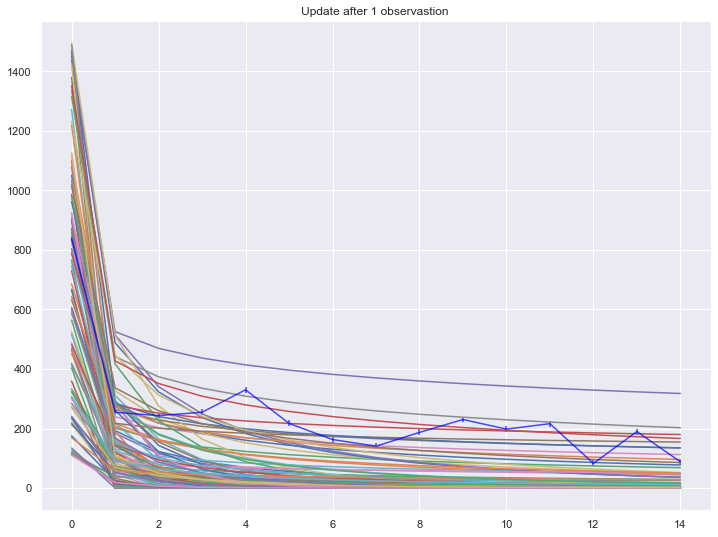

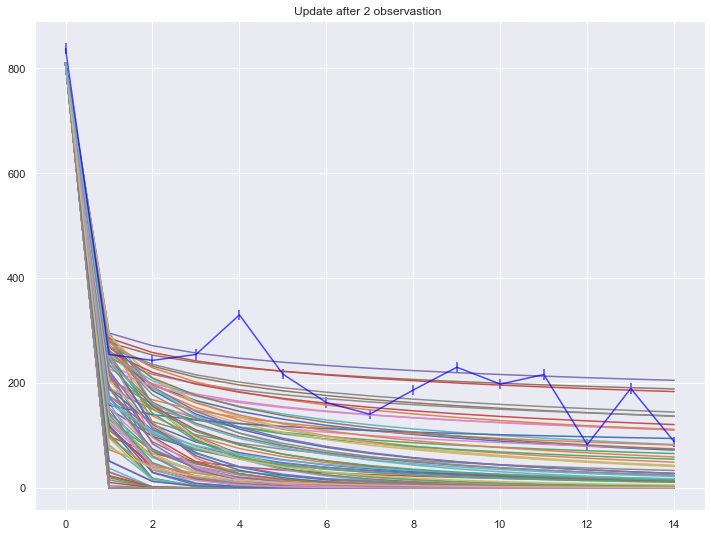

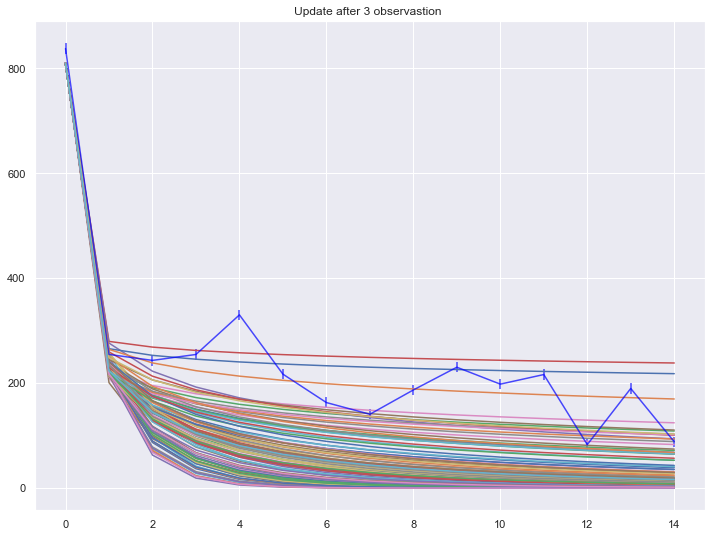

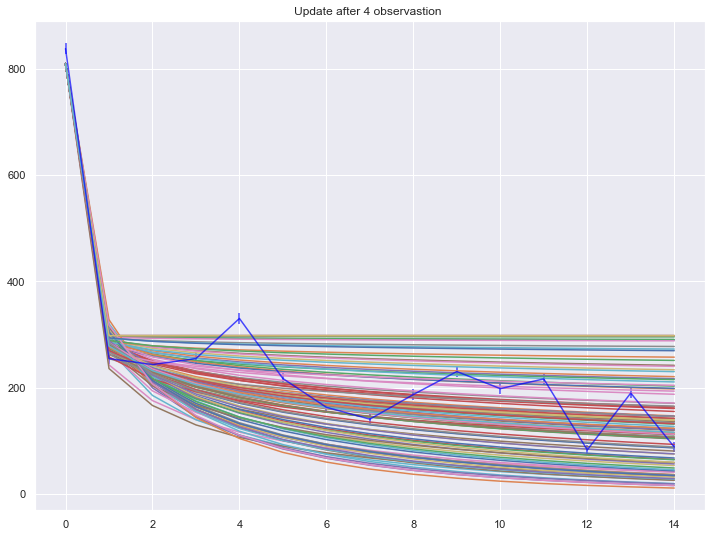

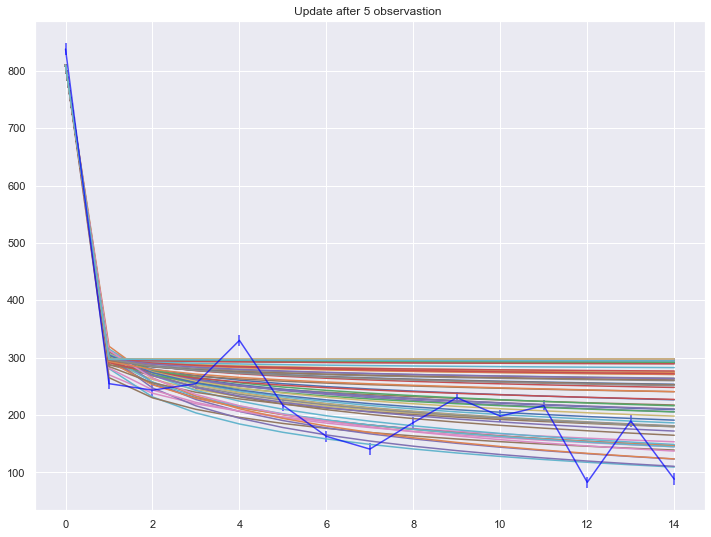

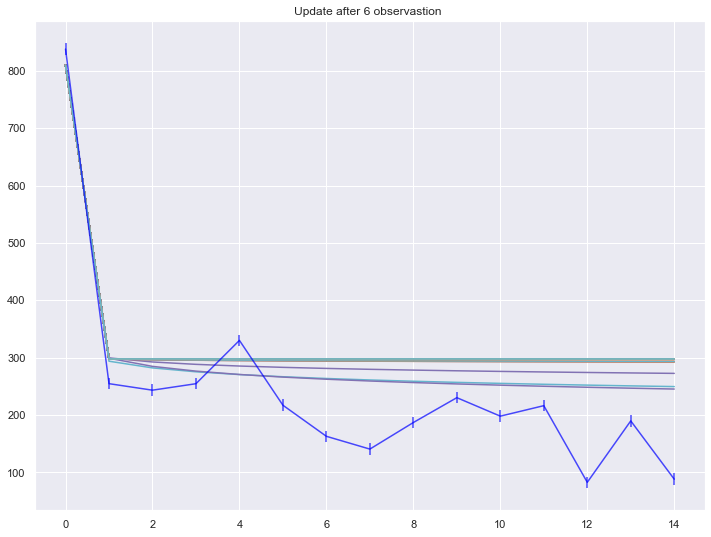

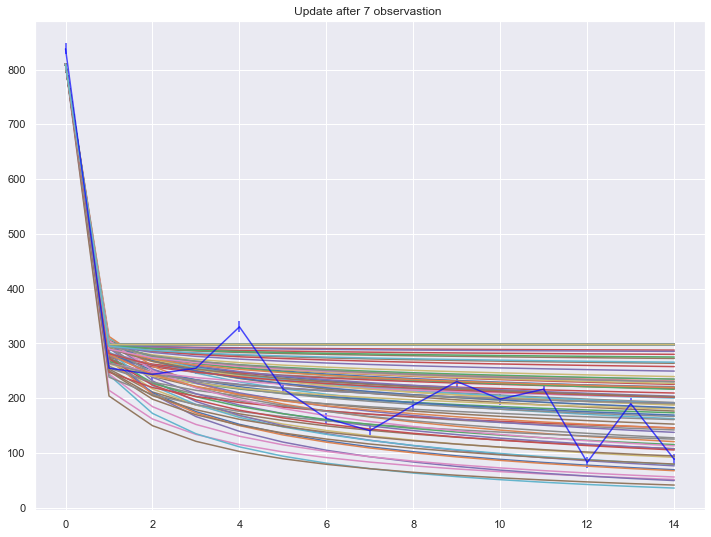

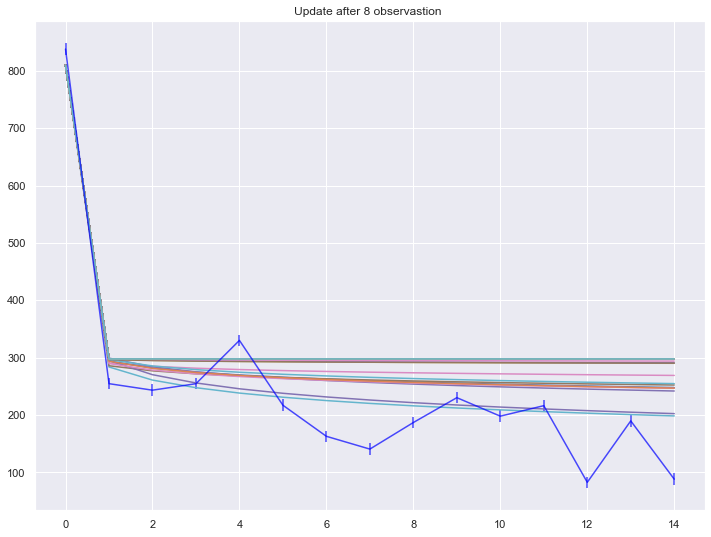

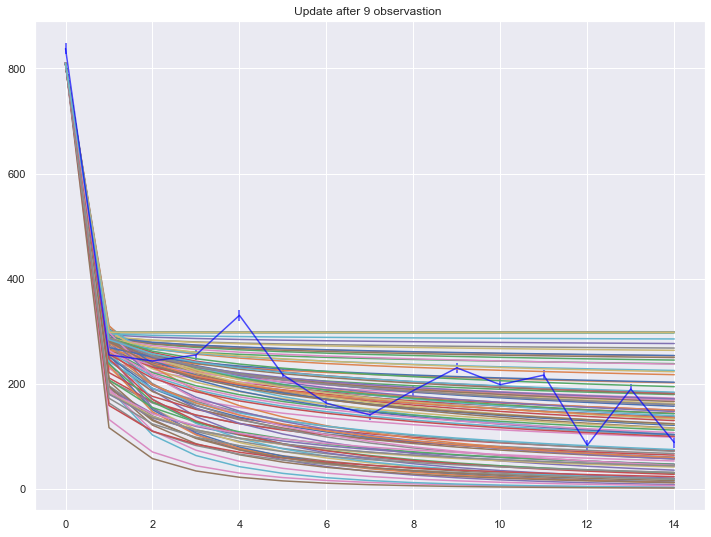

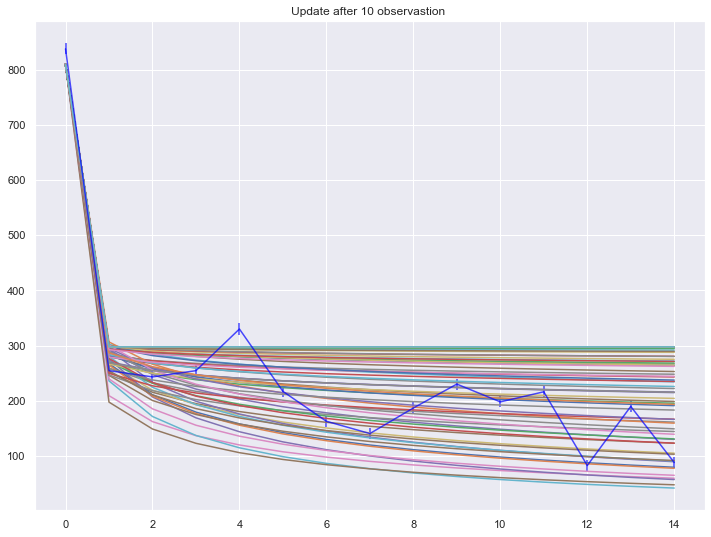

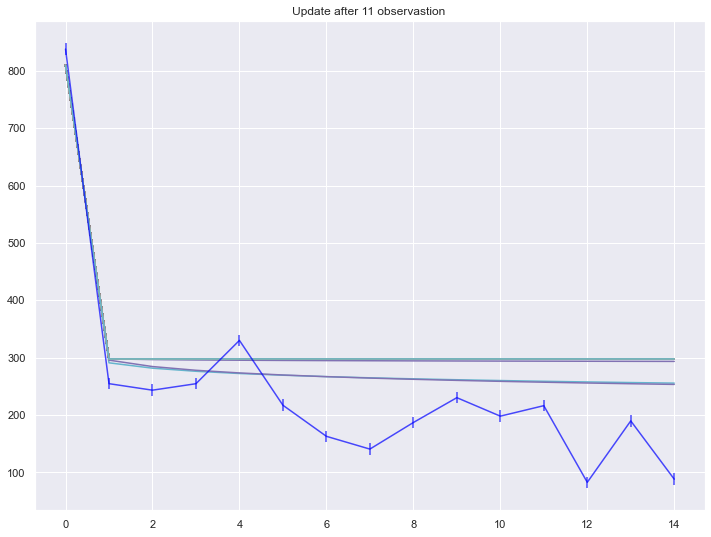

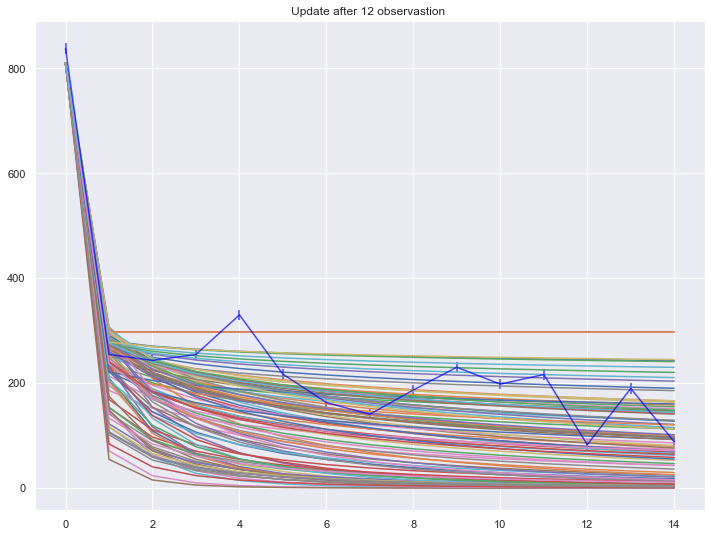

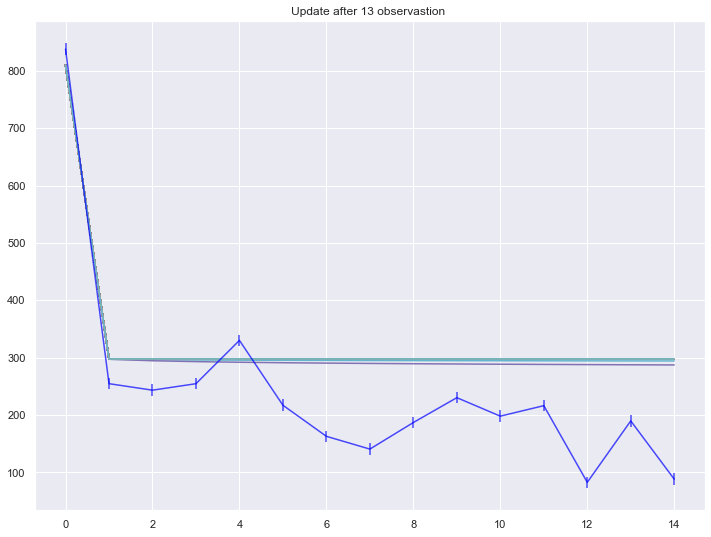

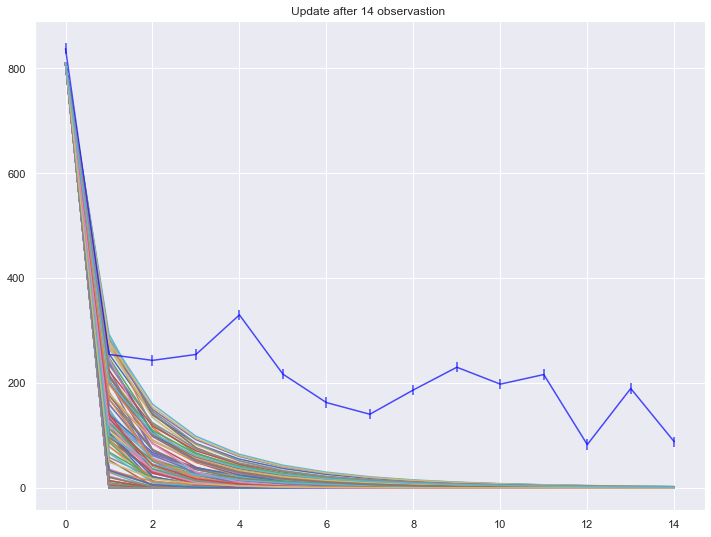

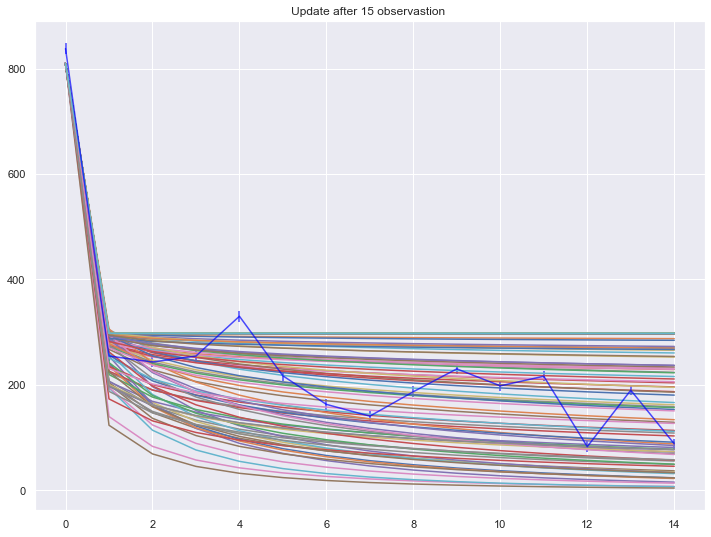

array([[809.60980797, 809.58474392, 809.59827073, ..., 809.58709635,
        809.61172312, 809.58767335],
       [297.83550543, 297.82807132, 297.83226518, ..., 297.72481538,
        297.83533885, 297.82964176],
       [297.83344097, 297.82600693, 297.83020075, ..., 297.29046438,
        297.83327439, 297.82757735],
       ...,
       [297.82810441, 297.82067054, 297.82486427, ..., 296.16769093,
        297.82793782, 297.82224094],
       [297.82786601, 297.82043214, 297.82462587, ..., 296.11753406,
        297.82769942, 297.82200255],
       [297.82764529, 297.82021143, 297.82440515, ..., 296.07109609,
        297.8274787 , 297.82178184]])

In [66]:
plotter(SEM_update,FM='SEM',tme=prod_time,trp=False)


In [ ]:
# plt.figure(figsize=(12,9))
# plt.errorbar(indx,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=1.5)
# plt.plot(indx,(SEM_update[4,:,1:]).T,alpha=.4)
# plt.ylabel('Rate(Updated SEM)')
# plt.xlabel('time')
# plt.title('Posterior and likelyhood')
# plt.legend()
# plt.show()

###  Mean and Std

In [ ]:


fig = plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
plt.plot(SEM_update[4,:,:].mean(axis=0),label='mean',color = "blue")

plt.subplot(2, 1, 2)
plt.plot(SEM_update[4,:,1:].std(axis=0),label='std',color = 'red')
plt.legend()
plt.xlabel('time')
plt.show()

In [ ]:
# plt.figure(figsize = (12,7))
# plt.plot(((np.array(tr) * np.ones((N,prod_time))).T-SEM_update[4,:,1:].T).mean(axis=1),label='mean')
# plt.plot(((np.array(tr) * np.ones((N,prod_time))).T-SEM_update[4,:,1:].T).std(axis=1),label='std')
# plt.legend()

In [67]:
def interpolator(df, xx):
    srt=df.sort_values(by=['x'], axis=0, ascending=True, inplace=False)
    mu = np.interp(xx,srt['x'],srt['mean'])
    std = np.interp(xx,srt['x'],srt['STD'])
    error_trm = ss.norm.rvs(mu,std**1,1)
    return error_trm
    

### EnKF V4 with adding model error

In [68]:
def EnKF_error(mf_k,Xf_k, gf_k, d, par1, par2, FM, pa_up ,er_cof,recur_error,st_df=0, r=.5):
    np.random.seed(663)
    random.seed(586)
    R = r * np.eye(1)
    N=mf_k.shape[1]
    nobs=(obs_SEM).shape[0]
    emf_K = np.zeros(mf_k.shape)
    Y_f_ = np.zeros([5,N,nobs+1])
    P_f_ = np.zeros([5,5,nobs+1])
    Y_a_ = np.zeros([5,N,nobs+1])
    P_a_ = np.zeros([5,5,nobs+1])
    Y_f_[0,:,0] = mf_k + emf_K
    Y_f_[1,:,0] = par1; Y_f_[2,:,0] = par2
    Y_f_[3,:,0] = mf_k + emf_K
    Y_f_[4,:,0] = mf_k + emf_K
    P_f_[:,:,0] = np.cov(Y_f_[:,:,0])
    Y_a_[0,:,0] = mf_k + emf_K
    Y_a_[1,:,0] = par1; Y_a_[2,:,0] = par2
    Y_a_[3,:,0] = mf_k + emf_K
    Y_a_[4,:,0] = mf_k + emf_K
    P_a_[:,:,0] = np.cov(Y_a_[:,:,0])
    if recur_error == False:
#####################################    
        Q0 = Y_a_[0,:,0]
        Q0e = np.zeros(Q0.shape)
        for v in range(Q0.shape[0]):
            Q0e[v] = interpolator(st_df,Q0[v])
        Q0=(Q0)+ er_cof* Q0e 
#####################################    
    for t in tqdm(range(nobs)):
        Q0 = Y_a_[0,:,t]
#####################################
        if recur_error == True:
            Q0e = np.zeros(Q0.shape)
            for v in range(Q0.shape[0]):
                Q0e[v] = interpolator(st_df,Q0[v])
            Q0=(Q0)+er_cof*Q0e    
#####################################

        if FM=='Arps':
            Qt=ArpsRate(np.array([range(t+1)]).T, Q0 ,Y_a_[1,:,t] , Y_a_[2,:,t])          #Arps(time, Q, Di0, b)
        else:
            Qt=SEM(np.array(([range(t+1)])*N).T, Q0 ,Y_a_[1,:,t],Y_a_[2,:,t])             #SEM(time, Q, Tau, n)

        #### recheck this part
        Y_f_[0,:,t+1] = Q0
        Y_f_[3,:,t+1] = Qt[t,:]
        Y_f_[4,:,t+1] = Qt[t,:]
        if pa_up== True: 
            Y_f_[1,:,t+1] = Y_a_[1,:,t];Y_f_[2,:,t+1] = Y_a_[2,:,t]
        else:
            Y_f_[1,:,t+1] = par1;Y_f_[2,:,t+1] = par2
        Y_f_now = Y_f_[:,:,t+1]
        P_f_now = np.cov(Y_f_now)*N/np.sqrt(N-1)
        P_f_[:,:,t+1] = P_f_now

        H = np.array([Qt[t,:] @  sla.pinv(Y_f_now)])   
        K = P_f_now @ H.T @ sla.pinv(H @ P_f_now @ H.T + R)
        y = d[t] + ss.norm.rvs(0,r,1) # measurement + noise
        
#         print("iteration", t)

#         print('p2',Y_f_now[2,2:4])
        Y_a_now = Y_f_now + K @ (y - H @ Y_f_now)
#         print("iteration", t)
#         print('p1',Y_f_now[1,2:4])
#         print('p2',Y_f_now[2,2:4])


        Y_a_now[1,:] = np.where(Y_a_now[1,:]<=0,10**-5, Y_a_now[1,:])
        Y_a_now[2,:] = np.where(Y_a_now[2,:]<=0,10**-5, Y_a_now[2,:])
        P_a_now = np.cov(Y_a_now)
        Y_a_[:,:,t+1] = Y_a_now
        P_a_[:,:,t+1] = P_a_now
    return Y_a_

In [69]:
Ar_er_up= EnKF_error(mf_k=np.matrix(para_mat[0,:]),                      #state_variables,, 
                    Xf_k=np.array(ARP_DF),                                 #dynamic_reservoir_model
                    gf_k=np.array(ARP_DF),                                 #observation_current
                    d=np.asarray(obs_SEM).T,                              #measurements
                    par1=(para_mat[1,:]),                                  #DCA paramter 1
                    par2=(para_mat[2,:]),                                  #DCA paramter 2
                    r=50,                                                 #R measurments error
                    FM='Arps',                                             #foreward model
                    st_df=df_out,                                         #error paramters
                    pa_up=True,                                          #updating paramter
                    er_cof = 1,                                        #Error multiplier
                    recur_error= False)                                  #recursively error adds up'True'


  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# RMSE with model error/ measurment is  2.184189465174983
# RMSE with model error/ ture is  14.568135512475697

In [ ]:
# plt.figure(figsize=(12,9))
# plt.errorbar(indx,np.asarray(obs_SEM), yerr = 10,color='blue',label='observation',alpha=.7)
# plt.plot(T,tr,label='True', color='red',linestyle='--',linewidth=1.5)
# plt.plot(indx,(Ar_er_up[4,:,1:]).T,alpha=.4)
# plt.ylabel('Rate')
# plt.xlabel('time')
# plt.title('Posterior and likelyhood')
# plt.legend()
# plt.show()

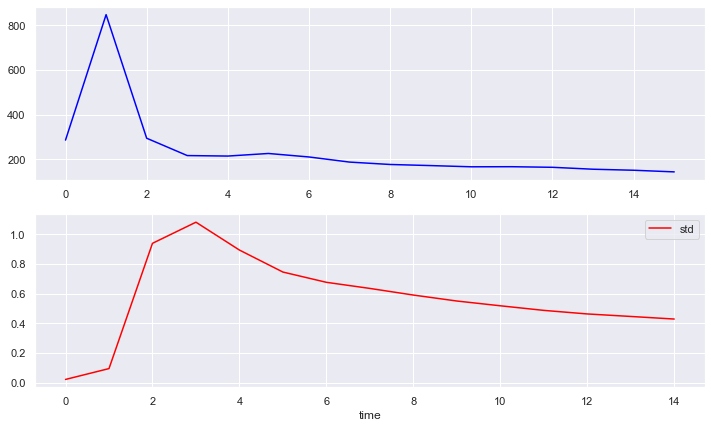

In [70]:
fig = plt.figure(figsize = (12,7))

plt.subplot(2, 1, 1)
plt.plot(Ar_er_up[4,:,:].mean(axis=0),label='mean',color = "blue")

plt.subplot(2, 1, 2)
plt.plot(Ar_er_up[4,:,1:].std(axis=0),label='std',color = 'red')
plt.legend()
plt.xlabel('time')
plt.show()

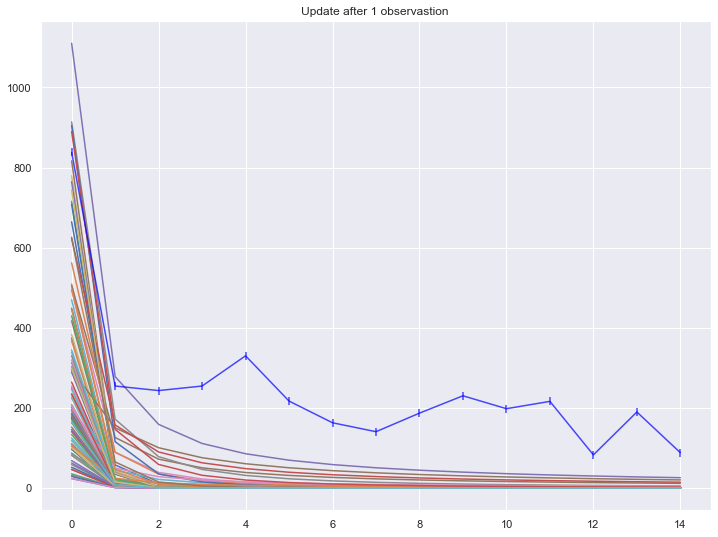

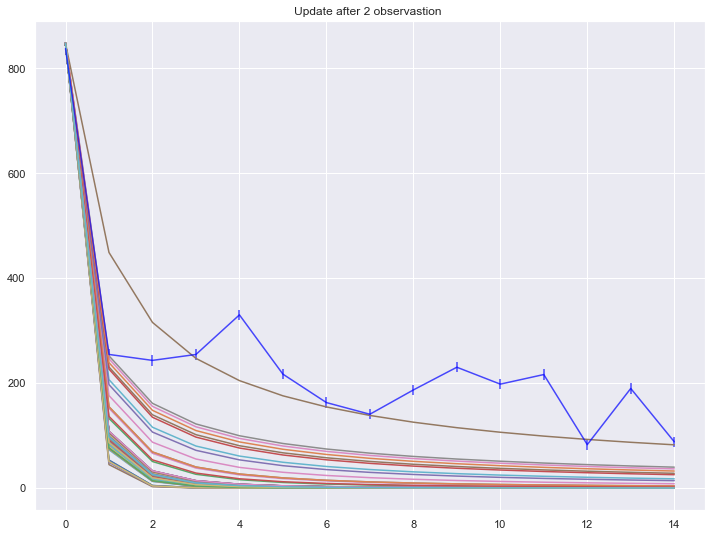

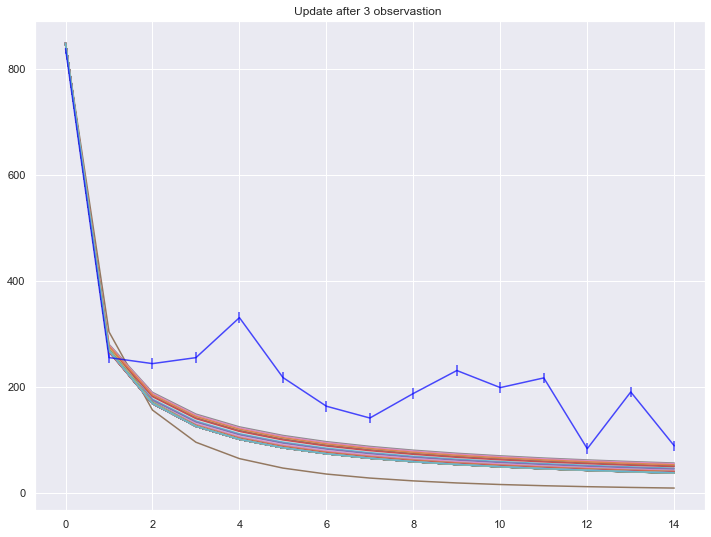

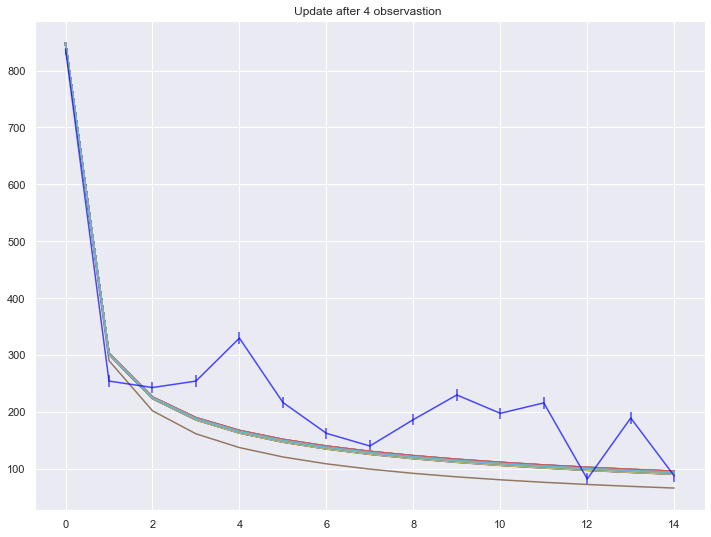

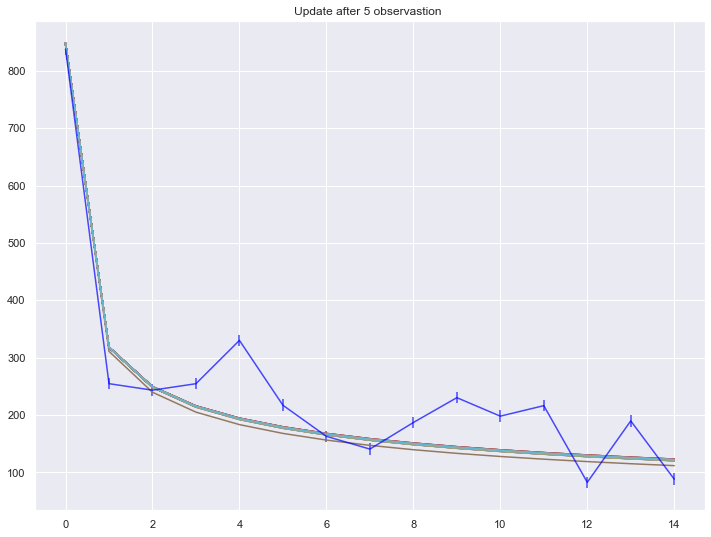

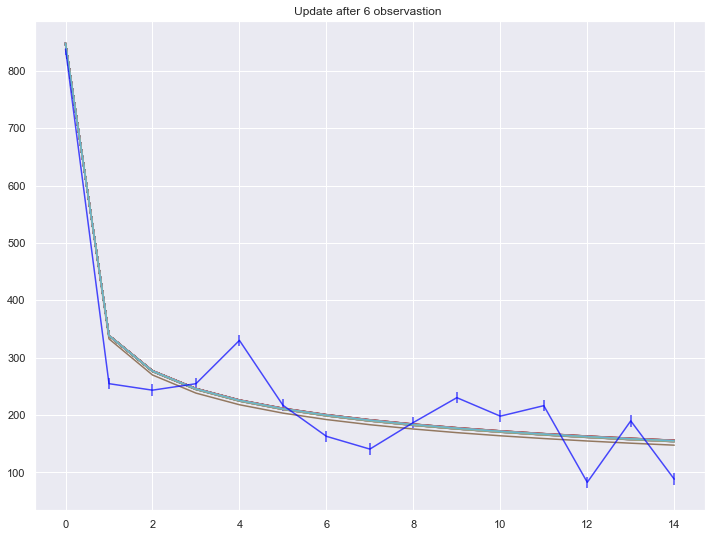

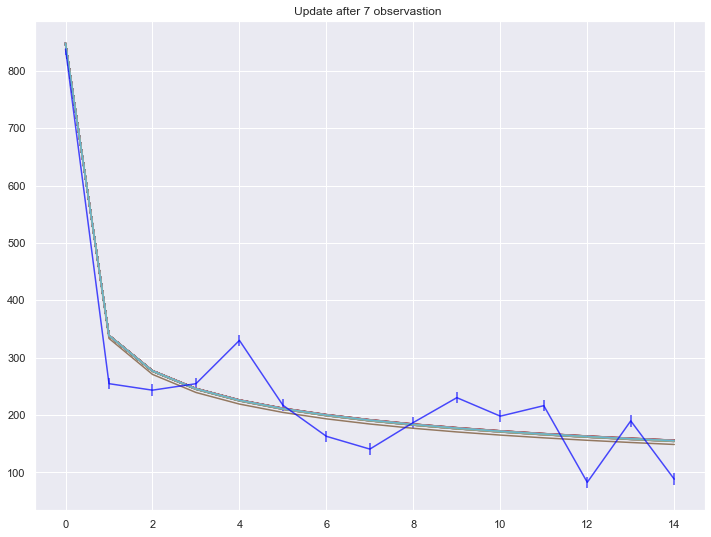

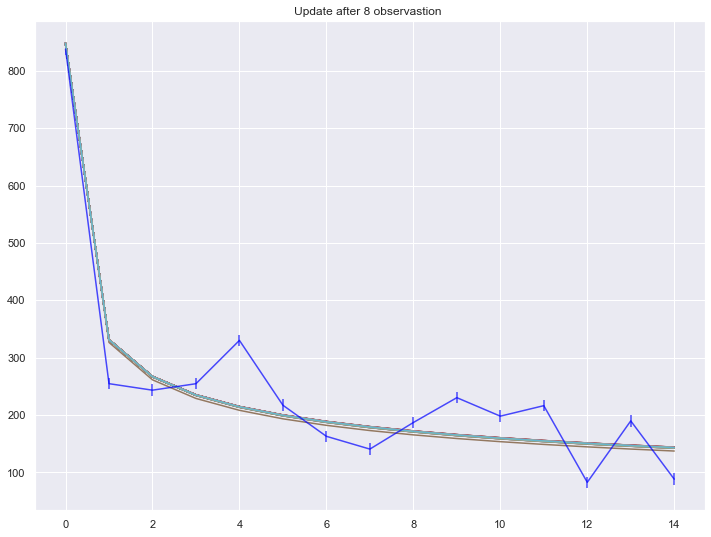

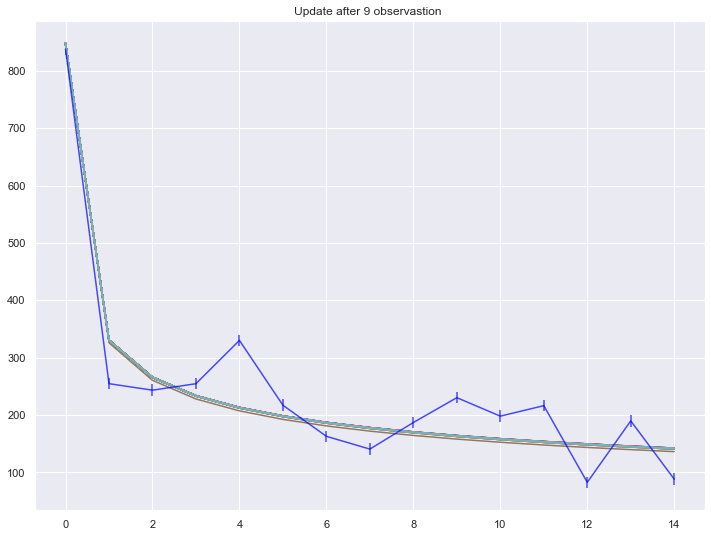

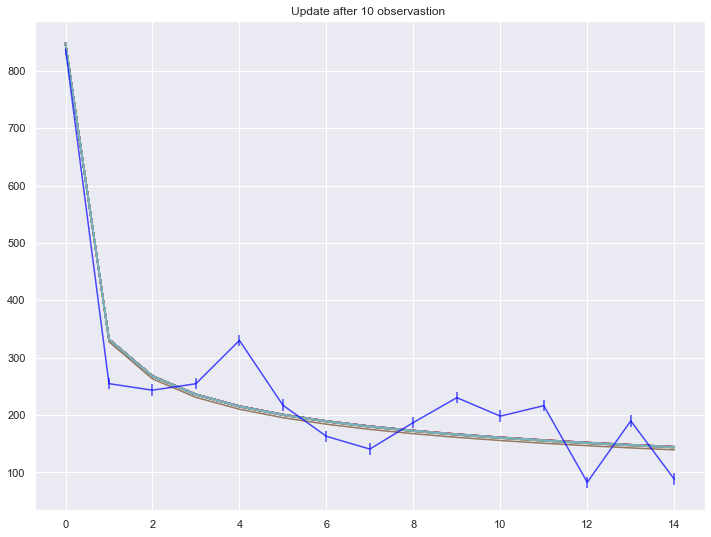

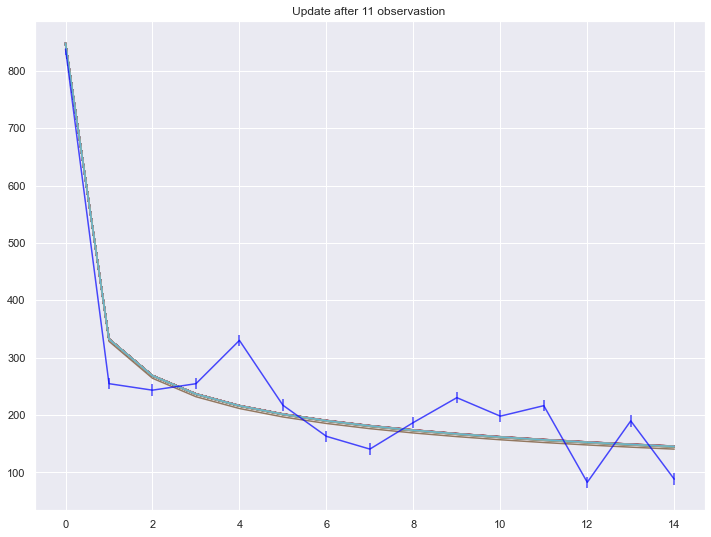

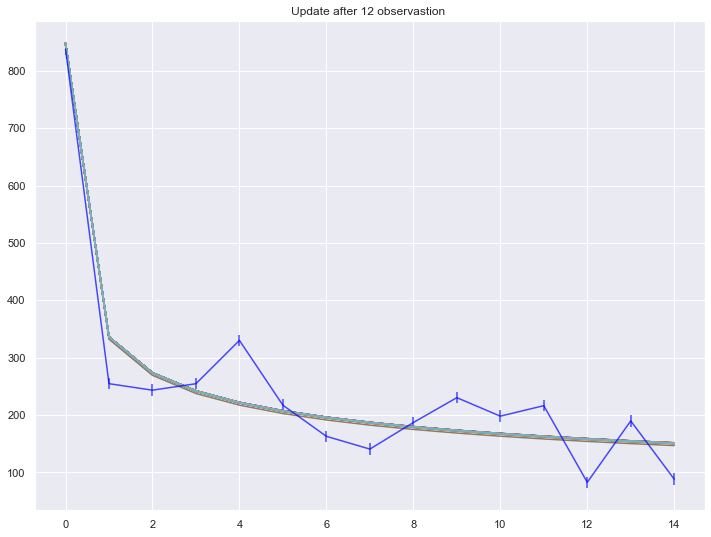

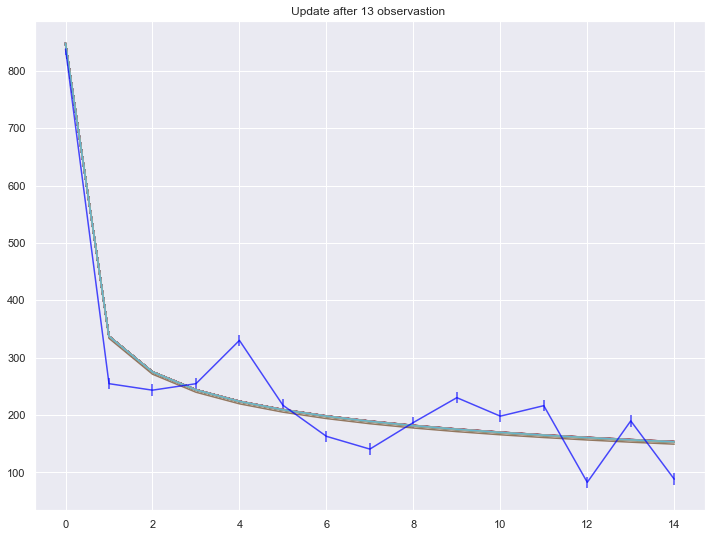

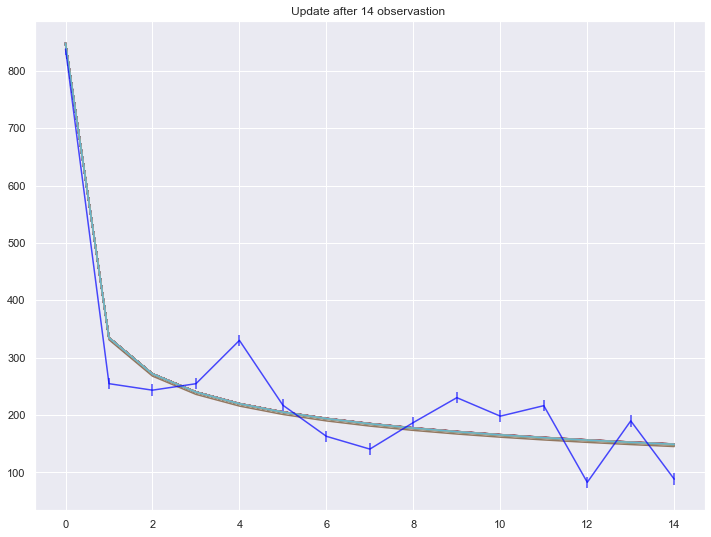

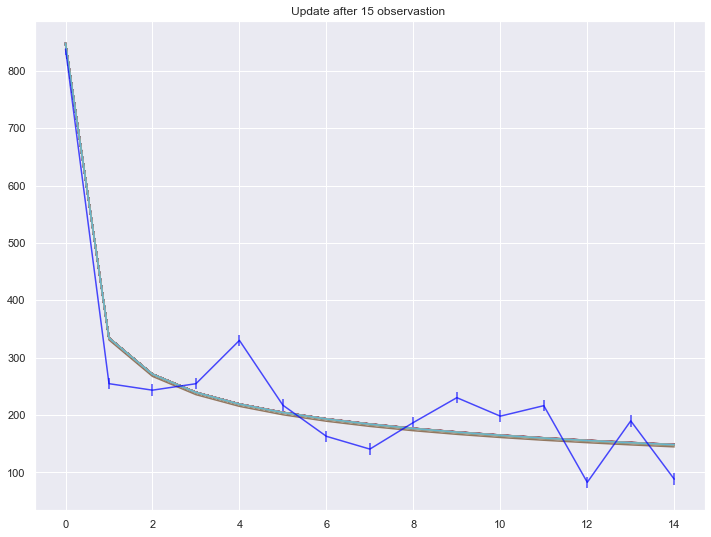

array([[847.66823729, 847.64014606, 847.65186577, ..., 847.64715206,
        847.65590603, 847.6446617 ],
       [334.38959356, 334.31402571, 334.34435609, ..., 334.33183777,
        334.35534651, 334.3253868 ],
       [271.09610981, 271.21451697, 271.17023995, ..., 271.18892561,
        271.15327195, 271.19831837],
       ...,
       [155.35325426, 155.72073555, 155.58044131, ..., 155.63925642,
        155.52755669, 155.66904123],
       [151.50564076, 151.87756275, 151.73554614, ..., 151.79507968,
        151.68202041, 151.82523036],
       [148.02719965, 148.40285097, 148.25938651, ..., 148.31952377,
        148.20532226, 148.34998202]])

In [73]:
plotter(Ar_er_up,FM='Arps',tme=prod_time,trp=False)


In [74]:
error(Ar_er_up,FM='Arps',tme=prod_time,tr =tr, obs= obs_SEM)

RMSE SEM_update/measrment is  44.70663853909479
RMSE SEM_update/ture is  22.500613443728543
MAPE SEM_update/measrment is  44.704162268124506
MAPE SEM_update/ture is  22.494817492254253


In [75]:
error(SEM_update,FM='SEM',tme=prod_time,tr =tr, obs= obs_SEM)

RMSE SEM_update/measrment is  162.1251507063844
RMSE SEM_update/ture is  137.59284561326066
MAPE SEM_update/measrment is  158.7513251090532
MAPE SEM_update/ture is  133.91919100885602


In [76]:
error(Arps_updated,FM='Arps',tme=prod_time,tr =tr, obs= obs_SEM)

RMSE SEM_update/measrment is  133.20637747789783
RMSE SEM_update/ture is  108.46540748366102
MAPE SEM_update/measrment is  132.68489530630222
MAPE SEM_update/ture is  107.98992652582423


In [ ]:
# from metalog import metalog # import the metalog package


# data = Ar_er_up[0,:,-1]
# metalog_fitted = metalog.fit(x=data.tolist(), boundedness='b', bounds=[np.min(data)-10, np.max(data)+10], term_limit=20)
# metalog.plot(m=metalog_fitted)

SEM Parameter>

(Initial paramter)
Q0 , Tau , n

Text(0.5, 1.0, ' Hist of Q0 SEM Initial')

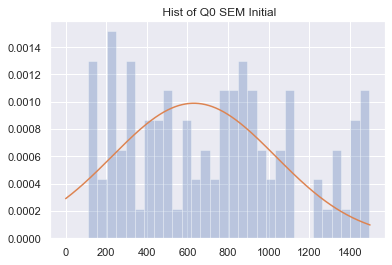

In [77]:
plt.hist(SEM_par[0,:],30,density = True,alpha = 0.3)
plt.plot(ss.norm.pdf(np.arange(100,1600),np.mean(SEM_par[0,:]),np.std(SEM_par[0,:])))
plt.title(" Hist of Q0 SEM Initial")

Text(0.5, 1.0, ' Hist of Tau SEM Initial')

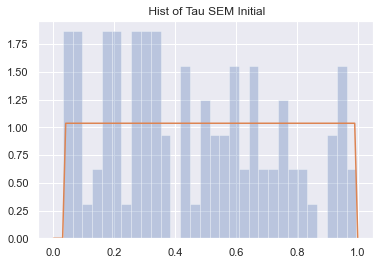

In [78]:

plt.hist(SEM_par[1,:],30,density = True,alpha = 0.3)
plt.plot(np.linspace(0,1,100),ss.uniform.pdf(np.linspace(0,1,100),np.min(SEM_par[1,:]),np.max(SEM_par[1,:])-np.min(SEM_par[1,:])))
plt.title(" Hist of Tau SEM Initial")

Text(0.5, 1.0, ' Hist of Tau SEM Initial')

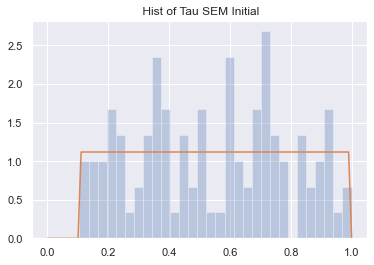

In [79]:
plt.hist(SEM_par[2,:],30,density = True,alpha = 0.3)
plt.plot(np.linspace(0,1,100),ss.uniform.pdf(np.linspace(0,1,100),np.min(SEM_par[2,:]),np.max(SEM_par[2,:])-np.min(SEM_par[2,:])))
plt.title(" Hist of Tau SEM Initial")

SEM Parameter>

(Updated paramter)
Q0 , Tau , n

In [ ]:
np.std(SEM_update[0,:,-1])

In [ ]:
plt.hist(SEM_update[0,:,-1],30,density = True,alpha = 0.3)
plt.plot(np.linspace(min(SEM_update[0,:,-1]),max(SEM_update[0,:,-1]),100), ss.norm.pdf(np.linspace(min(SEM_update[0,:,-1]),max(SEM_update[0,:,-1]),100), loc=np.mean(SEM_update[0,:,-1]),scale = np.std(SEM_update[0,:,-1])))
plt.title(" Hist of Q0 SEM update")

In [ ]:
plt.hist(SEM_update[1,:,-1],30,density = True,alpha = 0.3)
plt.plot(np.linspace(min(SEM_update[1,:,-1]),max(SEM_update[1,:,-1]),100), ss.norm.pdf(np.linspace(min(SEM_update[1,:,-1]),max(SEM_update[1,:,-1]),100), loc=np.mean(SEM_update[1,:,-1]),scale = np.std(SEM_update[1,:,-1])))
plt.title(" Hist of Tau SEM update")

In [ ]:
np.arange(0.0,1.2,100)

In [ ]:
plt.hist(SEM_update[2,:,-1],30,density = True,alpha = 0.3)
plt.plot(np.linspace(min(SEM_update[2,:,-1]),max(SEM_update[2,:,-1]),100), ss.norm.pdf(np.linspace(min(SEM_update[2,:,-1]),max(SEM_update[2,:,-1]),100), loc=np.mean(SEM_update[2,:,-1]),scale = np.std(SEM_update[2,:,-1])))
plt.title(" Hist of n SEM update")

Aprs Parameter>

(Initial paramter)
Q0 , Di , b

In [ ]:
mu_s = np.mean(para_mat[0,:])
sd_s = np.std(para_mat[0,:])

norm_mean = np.log(mu_s**2/np.sqrt(sd_s**2+mu_s**2))
norm_sd = np.sqrt(np.log(1+sd_s**2/mu_s**2))
y_cum= np.arange(len(para_mat[0,:]))/(len(para_mat[0,:])-1)
flognorm = lambda x: ss.lognorm(s=norm_sd, loc=0, scale=np.exp(norm_mean)).pdf(x)

x_fit_lognorm = np.linspace(min(para_mat[0,:]),max(para_mat[0,:]),100)
y_fit_lognorm = flognorm(x_fit_lognorm)    

plt.hist( para_mat[0,:],30, density = True,label='Data points',alpha = 0.3)
plt.plot(x_fit_lognorm, y_fit_lognorm, 'r--', lw=3,label='Lognorm dist')

plt.title(" Hist of Q0 Arps Initial with Curve fit ")

In [ ]:
mu_s = np.mean(para_mat[1,:])
sd_s = np.std(para_mat[1,:])

norm_mean = np.log(mu_s**2/np.sqrt(sd_s**2+mu_s**2))
norm_sd = np.sqrt(np.log(1+sd_s**2/mu_s**2))

flognorm = lambda x: ss.lognorm(s=norm_sd, loc=0, scale=np.exp(norm_mean)).pdf(x)

x_fit_lognorm = np.linspace(min(para_mat[1,:]),max(para_mat[1,:]+.001),100)
y_fit_lognorm = flognorm(x_fit_lognorm)    

plt.hist( para_mat[1,:],30,density = True, label='Data points',alpha = 0.3)
plt.plot(x_fit_lognorm, y_fit_lognorm, 'r-', lw=3,label='Lognorm dist')

plt.title(" Hist of Di Arps Initial with Curve fit ")

In [ ]:
mu_s = np.mean(para_mat[2,:])
sd_s = np.std(para_mat[2,:])

norm_mean = np.log(mu_s**2/np.sqrt(sd_s**2+mu_s**2))
norm_sd = np.sqrt(np.log(1+sd_s**2/mu_s**2))
y_cum= np.arange(len(para_mat[2,:]))/(len(para_mat[2,:])-1)
flognorm = lambda x: ss.lognorm(s=norm_sd, loc=0, scale=np.exp(norm_mean)).pdf(x)

x_fit_lognorm = np.linspace(min(para_mat[2,:]),max(para_mat[2,:]),100)
y_fit_lognorm = flognorm(x_fit_lognorm)    

plt.hist( para_mat[2,:],30, density = True,label='Data points',alpha = 0.3)
plt.plot(x_fit_lognorm, y_fit_lognorm, 'r-', lw=3,label='Lognorm dist')

plt.title(" Hist of b Arps Initial with Curve fit ")

Aprs Parameter>


(Updated paramter)
Q0 , Di , b

In [ ]:
plt.hist(Arps_updated[0,:,-1],30,density = True,alpha = 0.3)
plt.plot(np.linspace(min(Arps_updated[0,:,-1]),max(Arps_updated[0,:,-1]),100),ss.norm.pdf(np.linspace(min(Arps_updated[0,:,-1]),max(Arps_updated[0,:,-1]),100),np.mean(Arps_updated[0,:,-1]),np.std(Arps_updated[0,:,-1])))
plt.title(" Hist of Q0 Arps updated")

In [ ]:
plt.hist(Arps_updated[1,:,-1],30,density = True,alpha = 0.3)
plt.plot(np.linspace(min(Arps_updated[1,:,-1]),max(Arps_updated[1,:,-1]),100),ss.norm.pdf(np.linspace(min(Arps_updated[1,:,-1]),max(Arps_updated[1,:,-1]),100),np.mean(Arps_updated[1,:,-1]),np.std(Arps_updated[1,:,-1])))
plt.title(" Hist of Di Arps updated")

In [ ]:
plt.hist(Arps_updated[2,:,-1],30,density = True,alpha = 0.3)
plt.plot(np.linspace(min(Arps_updated[2,:,-1]),max(Arps_updated[2,:,-1]),100),
         ss.norm.pdf(np.linspace(min(Arps_updated[2,:,-1]),max(Arps_updated[2,:,-1]),100)
                     ,np.mean(Arps_updated[2,:,-1]),np.std(Arps_updated[2,:,-1])))
plt.title(" Hist of b Arps updated")

Model Error Parameter>
(Updated paramter)
Q0 , Di , b

In [ ]:
plt.hist(Ar_er_up[0,:,-1],bins=30,density=True,alpha = .3)
plt.plot(np.linspace(min(Ar_er_up[0,:,-1]),max(Ar_er_up[0,:,-1]),100),ss.norm.pdf(np.linspace(min(Ar_er_up[0,:,-1]),max(Ar_er_up[0,:,-1]),100),np.mean(Ar_er_up[0,:,-1]),np.std(Ar_er_up[0,:,-1])))
plt.title(" Hist of Q0 Model error updated")

In [ ]:
plt.hist(Ar_er_up[1,:,-1],bins=30,density=True,alpha = .3)
plt.plot(np.linspace(min(Ar_er_up[1,:,-1]),max(Ar_er_up[1,:,-1]),100),ss.norm.pdf(np.linspace(min(Ar_er_up[1,:,-1]),max(Ar_er_up[1,:,-1]),100),np.mean(Ar_er_up[1,:,-1]),np.std(Ar_er_up[1,:,-1])))
plt.title(" Hist of Di Model error updated")

In [ ]:
mu_s = np.mean(Ar_er_up[1,:,-1])
sd_s = np.std(Ar_er_up[1,:,-1])

norm_mean = np.log(mu_s**2/np.sqrt(sd_s**2+mu_s**2))
norm_sd = np.sqrt(np.log(1+sd_s**2/mu_s**2))

flognorm = lambda x: ss.lognorm(s=norm_sd, loc=0, scale=np.exp(norm_mean)).pdf(x)

x_fit_lognorm = np.linspace(min(Ar_er_up[1,:,-1]),max(Ar_er_up[1,:,-1]),100)
y_fit_lognorm = flognorm(x_fit_lognorm)    

plt.hist( Ar_er_up[1,:,-1],30,density = True, label='Data points',alpha = 0.3)
plt.plot(x_fit_lognorm, y_fit_lognorm, 'r--', lw=3,label='Lognorm dist')

plt.title(" Hist of Di Arps Initial with Curve fit ")

In [ ]:
plt.hist(Ar_er_up[2,:,-1],bins=30,density=True,alpha = .3)
plt.plot(np.linspace(min(Ar_er_up[2,:,-1]),max(Ar_er_up[2,:,-1]),100),ss.norm.pdf(np.linspace(min(Ar_er_up[2,:,-1]),max(Ar_er_up[2,:,-1]),100),np.mean(Ar_er_up[2,:,-1]),np.std(Ar_er_up[2,:,-1])))
plt.title(" Hist of b Model error updated")

In [ ]:
para_mis=np.zeros((3,N))
Cov_mis=np.zeros((3,N,3))
T_=T/max(T)
Mismatch
noise_sigma = T_/20

for i,column in tqdm(enumerate(Mismatch)):
    noise = np.random.rand(prod_time) * noise_sigma
    noise[noise<=0]=.01
    params,cov = curve_fit(ArpsRate,T_,Mismatch[column]/1, method ='trf',bounds=([0,.1,0.0001],[np.inf,5,2]),ftol=1.e-16,verbose=0,sigma=1/noise**2,
                           absolute_sigma=True)
    para_mis[:,i]=params
    Cov_mis[:,i,:]=cov

In [ ]:
Mis_updated= EnKF(mf_k=np.matrix(para_mis[0,:]),                      #state_variables,, 
                    Xf_k=np.array(Mismatch),                            #dynamic_reservoir_model
                    gf_k=np.array(Mismatch),                           #observation_current
                    d=np.asarray(obs_SEM),                            #measurements
                    par1=(para_mis[1,:]),                             #paramter1
                    par2=(para_mis[2,:]),                             #parameter2                                                    
                    r=50,                                             # measurements error (STD)
                    FM='Arps',                                        #forward model
                    st_df= df_out,                                     #statistical data
                   pa_up=True,                                        #updating parameters
                  tme=prod_time)

In [ ]:
a = plotter(Mis_updated,FM='Arps',tme=prod_time,trp=True)

In [ ]:
a.shape
np.mean(a,axis = 1),np.max(np.cov(a))